## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import geopandas as gpd
import matplotlib.colors as mcols
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask_gateway import GatewayCluster
from matplotlib.colors import LinearSegmentedColormap
from shared import (
    DIR_CIAM,
    DIR_RES,
    PATH_BORDERS,
    PATH_COASTLINES,
    PATH_DIAZ_INPUTS_INT,
    PATH_DIAZ_RES,
    PATH_GADM_0,
    PATH_GADM_1,
    PATH_MOVEFACTOR_DATA,
    PATH_PWT_RAW,
    PATH_QUANTILE_RES,
    PATH_SLIIDERS_ECON,
    PATH_SLIIDERS_SLR,
)

from pyCIAM.constants import COSTTYPES

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [9]:
DIR_FIGS = DIR_CIAM / "figures"

# Selected constants for plotting
CASES = ["optimalfixed", "noAdaptation"]
QUANTILES = [0.5]  # any combo of 0.05, 0.5, 0.95
DIAZSCENS = [
    "rcp0_p50",
    "rcp26_p50",
    "rcp45_p50",
    "rcp85_p50",
]  # rcp_pt dimension values in diaz results

DRATE = 0.04  # discount rate for calculating NPV (default is 4%)
RESENDYR = 2100  # last year of results to consider
NPVSTARTYR = 2000  # first year of results to use to calc NPV
POPWTYR = 2000  # year of population to use in % pop adaptation strategy plots
PPP_BASELINE_YEAR = 2019  # dollar value year of results
NWORKERS = 128  # no. of micro dask workers

# Names of all SSPs, IAMs
SSPS = ["SSP1", "SSP2", "SSP3", "SSP4", "SSP5"]
IAMS = ["OECD", "IIASA"]

# pyCIAM SLR, IAM, SSP scenarios to focus on for global maps
scen = "SLRProjections210628GRIDDEDcore_SROCC_rcp85"
iam = "IIASA"
ssp = "SSP2"

# color-blind robust palette for scatter plots
cols = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#50CAA8", "#56B4E9", "#E69F00"]

## Move Factor Plot

In [6]:
mf = xr.open_zarr(PATH_MOVEFACTOR_DATA)
mfdf = mf.sum("seg").to_dataframe()

# Convert to desired units
mfdf["K_2019"] = mfdf.K_2019 / 1e12  # trillions
mfdf["pop_2019"] = mfdf.pop_2019 / 1e6  # millions


# Find midpoint values of K and pop
# y vals
mid = mfdf.max() / 2

xint = np.abs(1 - mfdf / mid).idxmin()
xmid = xint.mean()

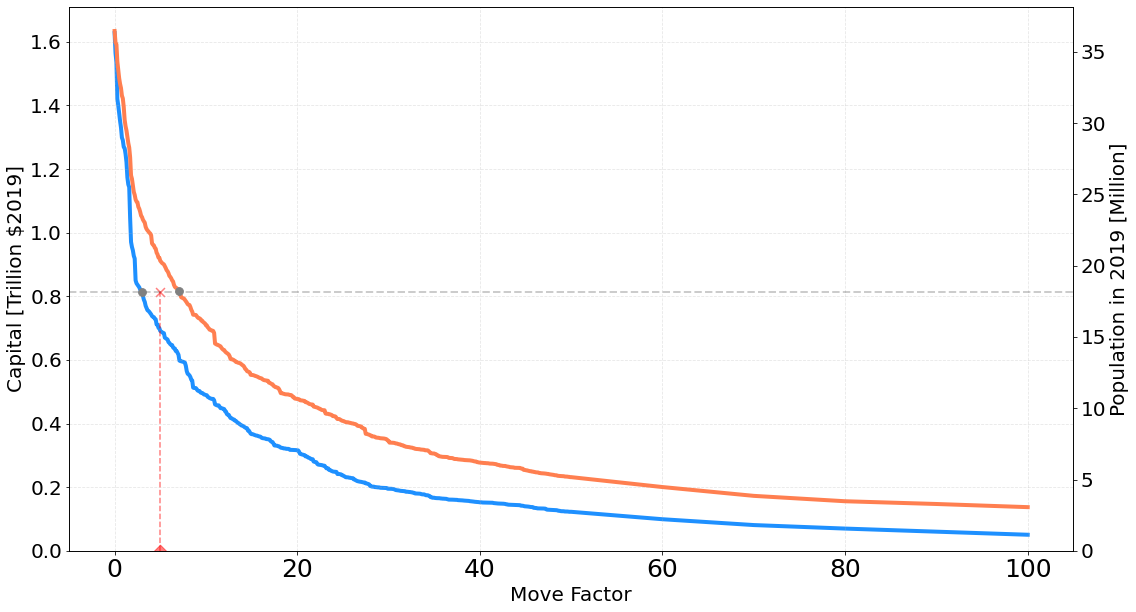

In [10]:
lw = 4  # linewidth
ms = 60  # marker size
mc = "grey"  # marker color
mt = "o"  # marker type

fig, ax = plt.subplots(1, 1, figsize=(18, 10))
ax2 = ax.twinx()
ax.xaxis.set_tick_params(labelsize=25)
ax.yaxis.set_tick_params(labelsize=20)
ax2.yaxis.set_tick_params(labelsize=20)

ax.plot(mfdf.K_2019, lw=lw, c="dodgerblue", zorder=1)
ax2.plot(mfdf.pop_2019, lw=lw, c="coral", zorder=1)

# Midpoint line (same height as popmid)
ax.axhline(mid.K_2019, linestyle="--", lw=2, c="k", alpha=0.2, zorder=3)

# Line intersections
ax.scatter([xint.K_2019], [mid.K_2019], marker=mt, s=ms, zorder=4, c=mc)
ax2.scatter([xint.pop_2019], [mid.pop_2019], s=ms, zorder=4, c=mc)
ax.grid(alpha=0.3, linestyle="--")

# Midpoint of intersections
ax.scatter([xmid], 0, marker="D", c="r", s=80, alpha=0.5)
ax.scatter([xmid], mid.K_2019, marker="x", c="r", s=80, alpha=0.5)
ax.vlines(xmid, 0, mid.K_2019, linestyles="--", colors="r", alpha=0.5)

# Align y-axes
ax.set_ylim(0, None)
ax2.set_ylim(0, None)
ax.set_xlabel("Move Factor", fontsize=20)
ax.set_ylabel("Capital [Trillion $2019]", fontsize=20)
ax2.set_ylabel("Population in 2019 [Million]", fontsize=20)
plt.savefig(DIR_FIGS / "movefactor_K_pop.png")

## Define Functions

### Helpers

In [149]:
def fillnan(ser):
    """fill NaNs or Infs in pd.Series object with 0"""
    return ser.where(np.isfinite(ser), 0)


def fillinf(ser):
    """fill Infs in pd.Series object with NaN"""
    return ser.where(~ser.isin([np.inf, -np.inf]))


def dfact(yrs, dr=DRATE, yr_mult=1, start_yr=NPVSTARTYR):
    """compute discount factor from costs variable"""
    dfy = yrs[yrs >= start_yr]
    nfill1 = len(yrs[yrs < start_yr])
    df_vals = np.append(
        np.array([1] * nfill1), (1 / (1 + DRATE)) ** (np.arange(len(dfy)) * yr_mult)
    )
    dfact = pd.Series(df_vals, index=yrs)
    dfact.index = dfact.index.rename("year")
    return dfact.to_xarray()

### Summarize Results

In [63]:
def diaz16_cnpv(
    ds,
    cstr="UnitedStates",
    case="optimalfixed",
    scen="rcp85_p50",
    year_min=2010,
    year_max=RESENDYR,
    year_int=10,
):
    """returns the country-wide NPV in pyCIAM results (Diaz 2016 configuration) for selected scenario and time period

    ----------
    ds : xr.Dataset
        pyCIAM results dataset
    cstr : str
        country name string in results
    case : str
        name of model case to be selected ("optimalfixed","noAdaptation")
    scen : str
        selected scenario in results to analyze
    year_min : int
        start year of results to use for NPV
    year_max : int
        end year of results to use for NPV
    year_max : int
        year interval in results
    """
    yrs = np.arange(year_min, year_max + year_int, year_int)
    segs = [v for v in list(ds.seg.values) if cstr in v]
    cnpv = (
        ds.npv.sel({"seg": segs, "case": case, "year": yrs, "rcp_pt": scen}).sum(
            ["seg", "year", "costtype"]
        )
    ) / 1e9  # $Bn

    return cnpv.item()


def opt_pct(
    DDIR=DIR_RES,  # results folder path
    scen="SLRProjections170113GRIDDEDcore_rcp85",  # SLR scenario
    sp_dim="seg_adm",  # spatial dimension to assess (seg_ir or seg_adm)
    quantile=True,  #
    idraw=10,
):
    """prints the percentage of coastal units by broad optimal strategy category

    Parameters
    ----------
    DDIR : PosixPath
        path to folder containing results zarr store
    scen : str
        selected scenario in results to analyze
    sp_dim : str
        name of spatial coastal unit dimension to assess (e.g. 'seg_ir', 'seg_adm')
    median : True/False
        do results represent median local sea level draws for SSP/IAM/SLR scenario combos?
    quantile : True/False
        do results contain a quantiles dimension?
    idraw : integer
        If median=False, this value is the draw (index) to be considered
    """

    opt_case = xr.open_zarr(PATH_QUANTILE_RES).optimal_case.sel(
        scenario=scen, drop=True
    )

    if quantile:
        opt_case = opt_case.sel(quantile=QUANTILES, drop=True)

    df = opt_case.sel(ssp="SSP1", iam="IIASA", drop=True).to_dataframe().reset_index()
    grp = df.groupby(["optimal_case"]).count()
    grp["pct_tot"] = 100 * (grp[sp_dim] / grp[sp_dim].sum())

    print(f"Protect: {np.round(grp.iloc[1:5].pct_tot.sum(),1)}%")
    print(f"Retreat: {np.round(grp.iloc[5:].pct_tot.sum(),1)}%")
    print(f"No Action: {np.round(grp.iloc[0].pct_tot.sum(),1)}%")


def ds_filt(
    pyCIAM_ds,
    diaz_ds,
    val="npv",
    case="optimalfixed",
    costtypes=COSTTYPES,
    cconly=False,
    year_min=NPVSTARTYR,
    year_max=RESENDYR,
):
    """Filter pyCIAM and Diaz2016 results datasets by variable, case, scenarios, years (used for plotting results subsets)

    Parameters
    ----------
    pyCIAM_ds : xr.Dataset
        dataset of pyCIAM results to be filtered
    diaz_ds : xr.Dataset
        dataset of pyCIAM (configured in Diaz2016 mode) results to be filtered
    val : str
        name of data variable to be selected in filtered output ("npv", "costs")
    case : str
        name of model case to be selected ("optimalfixed","noAdaptation")
    costtypes : list of str
        cost types to be selected ("inundation", "protection", ...)
    cconly : True/False
        conditional to select just climate-change scenarios (True) or all (False)
    year_min : int
        start year of results to select
    year_max : int
        end year of results to select

    Returns
    -------
    two xr.DataArray objects representing filtered results from input Datasets

    """
    pscens = pyCIAM_ds.scenario.values
    dscens = diaz_ds.rcp_pt.values

    if cconly:
        pscens = [s for s in pscens if "SLR" in s]
        dscens = [s for s in dscens if "rcp0" not in s]

    pc = (
        pyCIAM_ds[val]
        .sel(
            case=case,
            year=slice(year_min, year_max),
            scenario=pscens,
            costtype=costtypes,
        )
        .sum(["costtype", "year"])
    )  # pyCIAM filtered results

    dc = (
        diaz_ds[val]
        .sel(
            case=case,
            year=slice(year_min, year_max),
            rcp_pt=dscens,
            costtype=costtypes,
        )
        .sum(["costtype", "year"])
    )  # diaz-pyCIAM filtered results

    return pc, dc


# Print min/max values of filtered pyCIAM, Diaz results datasets for future scens
def ds_minmax(
    pyCIAM_da, diaz_da, val="npv", cconly=True, digits=6, div=1e12, units="$Tn"
):

    """prints the min/median/max valus from pyCIAM and Diaz-configures results datasets

    Parameters
    ----------
    pyCIAM_da : xr.DataArray
        data array of pyCIAM results
    diaz_da : xr.DataArray
        data array of pyCIAM (configured in Diaz2016 mode) results
    val : str
        results variable to summarize
    cconly : True/False
        only consider cliamte change scenarios (exclude no-climate change baseline)?
    digits : int
        number of digits to round printed values
    div : int
        divisor for variable values (e.g. 1e12 for trillions)
    units : str
        value units label
    """

    pscens = pyCIAM_da.scenario.values
    dscens = diaz_da.rcp_pt.values

    if cconly:
        pscens = [s for s in pscens if "SLR" in s]
        dscens = [s for s in dscens if "rcp0" not in s]

    p_df = pyCIAM_da.sel(scenario=pscens).to_dataframe()[val]
    pmin = p_df[p_df == p_df.min()]
    pmed_idx = abs(p_df - p_df.median()).idxmin()
    pmed_val = p_df.loc[abs(p_df - p_df.median()).idxmin()]
    pmax = p_df[p_df == p_df.max()]

    d_df = diaz_da.sel(rcp_pt=dscens).to_dataframe()[val]
    dmin = d_df[d_df == d_df.min()]
    dmed_idx = abs(d_df - d_df.median()).idxmin()
    dmed_val = d_df.loc[abs(d_df - d_df.median()).idxmin()]
    dmax = d_df[d_df == d_df.max()]

    print(
        f"pyCIAM min: {str(np.round(pmin[0]/div,digits))} {units} {str(pmin.index.tolist()[0])}"
    )

    print(f"pyCIAM med: {str(np.round(pmed_val/div,digits))} {units} {str(pmed_idx)}")

    print(
        f"pyCIAM max: {str(np.round(pmax[0]/div,digits))} {units} {str(pmax.index.tolist()[0])}"
    )

    print(
        f"Diaz 2016 min: {str(np.round(dmin[0]/div,digits))} {units} {str(dmin.index.tolist()[0])}"
    )

    print(
        f"Diaz 2016 med: {str(np.round(dmed_val/div,digits))} {units} {str(dmed_idx)}"
    )

    print(
        f"Diaz 2016 max: {str(np.round(dmax[0]/div,digits))} {units} {str(dmax.index.tolist()[0])}"
    )


def ds2df(pc, dc, div_fact=1e12):
    """converts filtered pyCIAM and diaz results to single dataframe (pre-plotting)
    Parameters
    ----------
    pc : xr.DataArray
        data array of filtered pyCIAM results
    dc : xr.DataArray
        data array of filtered pyCIAM (configured in Diaz2016 mode) results
    div_fact : int
        divisor for values (e.g. 1e12 for trillions)

    Returns
    ----------
    pd.DataFrame of both pyCIAM and pyCIAM-Diaz2016 values joined with end of century gmsl

    """
    pcdf = (pc / div_fact).to_dataframe()
    dcdf = (dc / div_fact).to_dataframe()

    dcdf["rcp"] = [v.split("_")[0] for v in dcdf.index.values]
    dcdf.loc[dcdf.rcp == "rcp0", "rcp"] = "ncc"
    dcdf["pctl"] = [v.split("_")[1] for v in dcdf.index.values]
    dcdf = dcdf.reset_index().drop(columns="rcp_pt")

    dcdf["ssp"] = np.nan
    dcdf["iam"] = np.nan
    dcdf["model"] = "diaz"

    pcdf = pcdf.reset_index().rename(columns={"scenario": "rcp"})
    pcdf["pctl"] = "p50"
    pcdf["model"] = "pyCIAM"

    df = pd.concat([dcdf, pcdf])

    df = df[df.pctl == "p50"]  # consider only median npv values for now

    # Join end of century GMSL values
    df = df.merge(gmsl)
    return df

### Plotting

In [13]:
def compPlot(
    df,
    yval="npv",
    ylab="",
    filename="myplot",
    xmin=-0.05,
    xmax=1.3,
    ymin=0,
    ymax=8,
    ssps=SSPS,
    iams=IAMS,
    cvals=cols[0:5],
):
    """plots results from ds2df() function for scatter plotting pyCIAM/diaz results vs gmsl
    Parameters
    ----------
    df : pd.DataFrame
        dataframe from ds2df()
    yval : str
        variable name for plotting
    ylab : str
        label for y axis values
    filename : str
        name of output graph file (.png)
    xmin, xmax, ymin, ymax : float
        figure axes ranges

    Returns
    ----------
    displayed scatter plot and saved .png of figure

    """
    fig, ax = plt.subplots(1, 1, figsize=(20, 4))
    ax.xaxis.set_tick_params(labelsize=25)
    ax.yaxis.set_tick_params(labelsize=20)

    sspc = cvals
    for i, s in enumerate(ssps):
        for m in iams:
            filt = df[(df.ssp == s) & (df.iam == m)]
            marker = "o"
            if m == "IIASA":
                marker = "^"

            ax.scatter(
                filt.gmsl, filt[yval], marker=marker, c=sspc[i], s=100, alpha=0.8
            )

    # Diaz 2016
    ax.scatter(
        df[df.model == "diaz"].gmsl,
        df[df.model == "diaz"][yval],
        s=120,
        marker="s",
        c="black",
    )

    ax.grid(alpha=0.2, linestyle="--")
    plt.ylim(ymin, ymax)
    plt.xlim(xmin, xmax)
    plt.ylabel(ylab)
    plt.savefig(DIR_FIGS / str(filename + ".png"))

## Spin up Dask Workers

In [14]:
cluster = GatewayCluster(idle_timeout=3600, profile="micro")
client = cluster.get_client()
cluster.scale(NWORKERS)
cluster

## Import Data

### SLR

In [15]:
# Import SLR dataset to get GMSL values ##
slr = xr.open_zarr(PATH_SLIIDERS_SLR)
slryrs = slr.year.values
slr = slr.interp(year=np.arange(min(slryrs), max(slryrs) + 1, 1))  # decadal to annual

# Save GMSL in end of results period (e.g. 2100) as dataframe
gmsl = (
    slr.gsl_msl00.sel(year=RESENDYR).median("mc_sample_id").drop("year").to_dataframe()
)

# Add median GMSL @ end of century values from Kopp et al. 2014 for the Diaz 2016 scenarios
gmsl.loc["rcp26"] = gmsl.loc["SLRProjections170113GRIDDEDcore_rcp26"].values
gmsl.loc["rcp45"] = gmsl.loc["SLRProjections170113GRIDDEDcore_rcp45"].values
gmsl.loc["rcp85"] = gmsl.loc["SLRProjections170113GRIDDEDcore_rcp85"].values
gmsl.loc["ncc"] = 0

gmsl = gmsl.gsl_msl00.reset_index().rename(
    columns={"scenario": "rcp", "gsl_msl00": "gmsl"}
)

# Jitter 2100 GMSL by +/-7mm for Bamber19 High bc and D20 RCP8.5 for plotting purposes
if RESENDYR == 2100:
    gmsl.loc[gmsl.rcp == "SLRProjections190726core_SEJ_full_rcp85+H", "gmsl"] = (
        gmsl.loc[gmsl.rcp == "SLRProjections190726core_SEJ_full_rcp85+H", "gmsl"]
        - 0.007
    )
    gmsl.loc[gmsl.rcp == "SLRProjections200204GRIDDEDcore_D20_rcp85", "gmsl"] = (
        gmsl.loc[gmsl.rcp == "SLRProjections200204GRIDDEDcore_D20_rcp85", "gmsl"]
        + 0.007
    )

# Display GMSL values in 2100
gmsl.sort_values("gmsl")

rcp   gmsl
14                                            ncc  0.000
2           SLRProjections170113GRIDDEDcore_rcp26  0.490
11                                          rcp26  0.490
8     SLRProjections210628GRIDDEDcore_SROCC_rcp26  0.500
5       SLRProjections200204GRIDDEDcore_D20_rcp26  0.530
3           SLRProjections170113GRIDDEDcore_rcp45  0.590
12                                          rcp45  0.590
9     SLRProjections210628GRIDDEDcore_SROCC_rcp45  0.610
6       SLRProjections200204GRIDDEDcore_D20_rcp45  0.630
0   SLRProjections190726core_SEJ_full_2p0degree+L  0.690
4           SLRProjections170113GRIDDEDcore_rcp85  0.790
13                                          rcp85  0.790
10    SLRProjections210628GRIDDEDcore_SROCC_rcp85  0.890
1       SLRProjections190726core_SEJ_full_rcp85+H  1.103
7       SLRProjections200204GRIDDEDcore_D20_rcp85  1.117

In [16]:
# Show proporiton of coastal units (e.g. seg_adm) that undertake protect/retreat/noAdapt actions
opt_pct()

Protect: 16.7%
Retreat: 68.0%
No Action: 15.4%


### SLIIDERS/Diaz Input Data

In [25]:
# pyCIAM inputs
inputs = xr.open_zarr(PATH_SLIIDERS_ECON, consolidated=True)

# diaz16 inputs
d16inputs = (
    xr.open_zarr(PATH_DIAZ_INPUTS_INT, consolidated=True)
    .reindex(year=np.arange(2000, 2201, 1))
    .ffill("year")
)

# pyCIAM results
res = (
    xr.open_zarr(PATH_QUANTILE_RES, consolidated=True)
    .sel(case=CASES, quantile=QUANTILES, drop=True)
    .squeeze(drop=True)
    .persist()
)  # [2019 USD / year]

yrs = res.year.values
scens = res.scenario.values
scens_cc = [s for s in scens if "SLR" in s]

# Diaz 2016
# Decadal
d16 = (
    (xr.open_zarr(PATH_DIAZ_RES, consolidated=True).drop("at"))
    .sel(case=CASES, rcp_pt=DIAZSCENS)
    .load()
)  # [2019 USD / year]

# Annual
d16a = d16.reindex(year=np.arange(2000, 2201, 1)).ffill("year")

d16yrs = d16.year.values
d16ayrs = d16a.year.values

d16["costs"] = d16.costs * 10  # annual to decadal totals
d16_med_scens_cc = [s for s in DIAZSCENS if "rcp0" not in s]

## pyCIAM (CIAM config) Diaz16 paper results comp

In [26]:
# Add NPV to annual Diaz16 results
d16["npv"] = d16.costs * dfact(d16.year.values, yr_mult=10, start_yr=2010)

# Global NPV (2010-2100) [$Tn]
d16.npv.sel(
    year=slice(2010, 2100), case="optimalfixed", rcp_pt="rcp85_p50"
).sum().item() / 1e12

1.6922457274046747

In [32]:
d16_85 = d16.costs.sel(rcp_pt="rcp85_p50")

In [33]:
# Wetland Costs in 2100 [$Bn] (annualizing the decadal costs)
d16_85.sel(
    year=RESENDYR, case="optimalfixed", costtype="wetland"
).sum().item() / 10 / 1e9

79.29315740954944

In [34]:
# Global Costs in 2100 (optimal adapt) [$Bn]
d16_85.sel(year=RESENDYR, case="optimalfixed").sum().item() / 10 / 1e9

282.0671058445753

In [35]:
# Global Costs in 2100 (no adapt) [$Tn]
d16_85.sel(year=RESENDYR, case="noAdaptation").sum().item() / 10 / 1e12

2.251455307220169

### Country-wise NPV values

In [40]:
# USA
diaz16_cnpv(d16, "UnitedStates")

419.73063721683513

In [41]:
# Brazil
diaz16_cnpv(d16, "Brazil")

97.49543069735755

In [42]:
# Australia
diaz16_cnpv(d16, "Australia")

208.55586382513653

In [43]:
# China
a = diaz16_cnpv(d16, "China")
b = diaz16_cnpv(d16, "Taiwan")
c = diaz16_cnpv(d16, "HongKong")
d = diaz16_cnpv(d16, "Macau")

a - b - c - d

86.99817109318086

## Inflation Adjust Diaz, Calc NPV, CC-only Values

In [44]:
# adjust to 2019 USD from 2010 USD
pl_data = pd.read_excel(PATH_PWT_RAW)[["countrycode", "year", "pl_gdpo"]]

pl_data = (
    pl_data[
        (pl_data.year >= 2010)
        & (pl_data.year <= PPP_BASELINE_YEAR)
        & (pl_data.countrycode == "USA")
    ]
    .drop(columns="countrycode")
    .set_index("year")
    .pl_gdpo
)
pl_multiplier = pl_data[PPP_BASELINE_YEAR] / pl_data[2010]

# Inflation-adjust Diaz 2016 values to $2019
d16["costs"] = d16["costs"] * pl_multiplier
d16a["costs"] = d16a["costs"] * pl_multiplier

In [45]:
# Create NPV variables for pyCIAM and annual Diaz16 results
res["npv"] = res.costs * dfact(res.year.values, start_yr=NPVSTARTYR)
d16["npv"] = d16.costs * dfact(d16.year.values, start_yr=NPVSTARTYR, yr_mult=10)
d16a["npv"] = d16a.costs * dfact(d16a.year.values, start_yr=NPVSTARTYR)

In [46]:
# Create CC-only Costs
res_cc = res - res.sel(scenario="ncc")

diaz_p50 = ["rcp0_p50", "rcp26_p50", "rcp45_p50", "rcp85_p50"]
d16a_cc = d16a.sel(rcp_pt=diaz_p50) - d16a.sel(rcp_pt="rcp0_p50")

## Print Values for Abstract & Intro

In [49]:
r45 = [i for i in res.scenario.values if "rcp45" in i]  # RCP4.5 scenarios
highend = [
    "SLRProjections200204GRIDDEDcore_D20_rcp85",
    "SLRProjections190726core_SEJ_full_rcp85+H",
]  # high end scenarios

In [50]:
res_sums = (
    res_cc.sel(case="optimalfixed", scenario=r45 + highend, ssp=ssp, iam=iam)
    .sum(["costtype", "seg_adm"])
    .load()
)

### NPV, RCP4.5

In [51]:
res_r45 = res_sums.sel(scenario=r45)
res_r45_sum = res_r45.npv.sum("year") / 1e12
res_r45_sum.min().item(), res_r45_sum.max().item()

(0.8709738959550647, 0.9210818640110986)

### Annual Costs, RCP4.5

In [52]:
res_r45_costs = res_r45.costs.sel(year=RESENDYR) / 1e9
res_r45_costs.min().item(), res_r45_costs.max().item()

(176.27589416503906, 204.88446044921875)

### NPV, High-End

In [53]:
res_hi = res_sums.sel(scenario=highend)
res_hi_sum = res_hi.npv.sum("year") / 1e12
res_hi_sum.min().item(), res_hi_sum.max().item()

(1.2167099404903126, 1.3783266829277723)

### Annual Costs, High-End

In [54]:
res_hi_costs = res_hi.costs.sel(year=RESENDYR) / 1e9
res_hi_costs.min().item(), res_hi_costs.max().item()

(395.80169677734375, 520.6741333007812)

## Compare Diaz 2016 reported values to pyCIAM (Scatter Plots)

### Global NPV

#### optimal, total

In [61]:
res_global = res.sum("seg_adm").load()
d16_global = d16a.sum("seg")

pyCIAM min: 5.385841 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 5.91507 $Tn ('SLRProjections190726core_SEJ_full_2p0degree+L', 'SSP2', 'IIASA')
pyCIAM max: 7.668521 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'OECD')
Diaz 2016 min: 1.459305 $Tn rcp26_p50
Diaz 2016 med: 1.574431 $Tn rcp45_p50
Diaz 2016 max: 1.810862 $Tn rcp85_p50


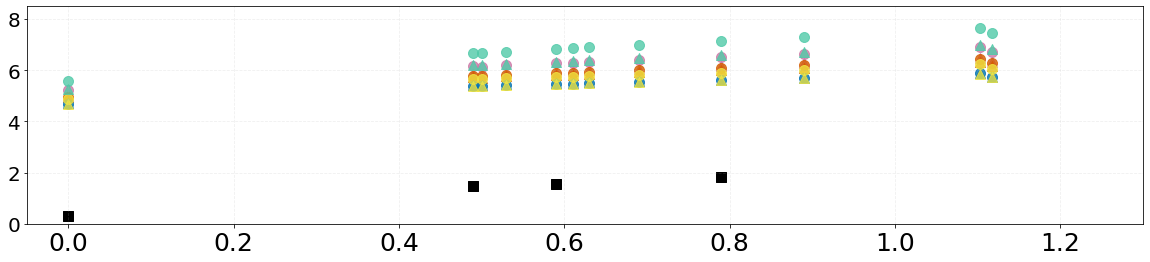

In [64]:
pc, dc = ds_filt(res_global, d16_global)
ds_minmax(pc, dc, cconly=True)
compPlot(ds2df(pc, dc), filename="global_npv_total_opt", ymax=8.5)

In [56]:
df = ds2df(pc, dc)

k14 = [
    "SLRProjections170113GRIDDEDcore_rcp26",
    "SLRProjections170113GRIDDEDcore_rcp45",
    "SLRProjections170113GRIDDEDcore_rcp85",
]

print("pyCIAM K14 NPV min/med/max (no ncc)")
print(df[(df.model == "pyCIAM") & (df.rcp.isin(k14))].npv.min())
print(df[(df.model == "pyCIAM") & (df.rcp.isin(k14))].npv.median())
print(df[(df.model == "pyCIAM") & (df.rcp.isin(k14))].npv.max())
print("")

pyCIAM K14 NPV min/med/max (no ncc)
5.3908443072928405
5.870717492215766
7.15309212346801



#### optimal, CC-only

In [70]:
res_cc_global = res_cc.sum("seg_adm").load()
d16a_cc_global = d16a_cc.sum("seg")

pyCIAM min: 0.679736 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP3', 'IIASA')
pyCIAM med: 0.97542 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp85', 'SSP3', 'IIASA')
pyCIAM max: 2.078961 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'OECD')
Diaz 2016 min: 1.140808 $Tn rcp26_p50
Diaz 2016 med: 1.255934 $Tn rcp45_p50
Diaz 2016 max: 1.492365 $Tn rcp85_p50


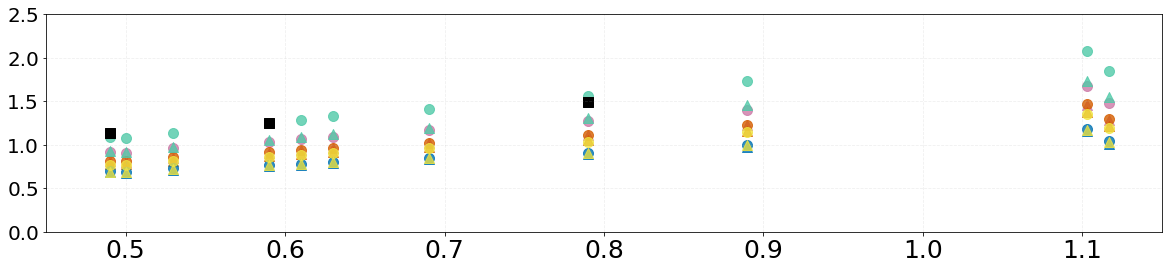

In [71]:
pc, dc = ds_filt(res_cc_global, d16a_cc_global, cconly=True)
ds_minmax(pc, dc)
compPlot(
    ds2df(pc, dc), filename="global_npv_CC_opt", xmin=0.45, xmax=1.15, ymin=0, ymax=2.5
)

#### noAdapt, total

pyCIAM min: 29.226669 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 32.083536 $Tn ('SLRProjections170113GRIDDEDcore_rcp45', 'SSP5', 'IIASA')
pyCIAM max: 41.036766 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'OECD')
Diaz 2016 min: 6.863121 $Tn rcp26_p50
Diaz 2016 med: 7.751697 $Tn rcp45_p50
Diaz 2016 max: 9.204644 $Tn rcp85_p50


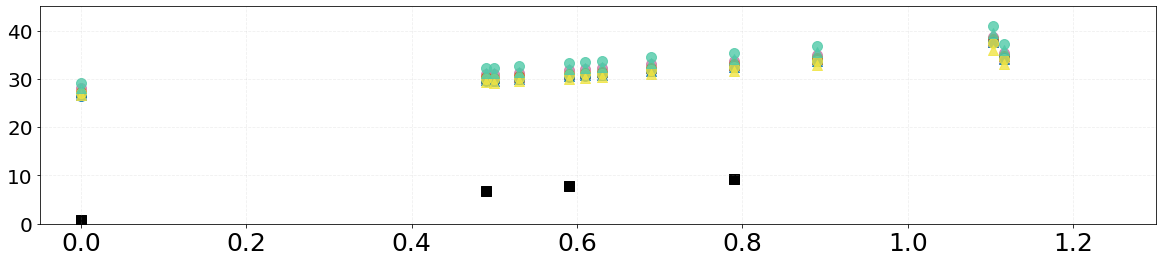

In [72]:
pc, dc = ds_filt(res_global, d16_global, case="noAdaptation")
ds_minmax(pc, dc)
compPlot(ds2df(pc, dc), filename="global_npv_total_noAdapt", ymax=45)

#### noAdapt, CC-only

pyCIAM min: 2.664435 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 4.199387 $Tn ('SLRProjections200204GRIDDEDcore_D20_rcp45', 'SSP2', 'OECD')
pyCIAM max: 11.905142 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'OECD')
Diaz 2016 min: 6.072762 $Tn rcp26_p50
Diaz 2016 med: 6.961338 $Tn rcp45_p50
Diaz 2016 max: 8.414284 $Tn rcp85_p50


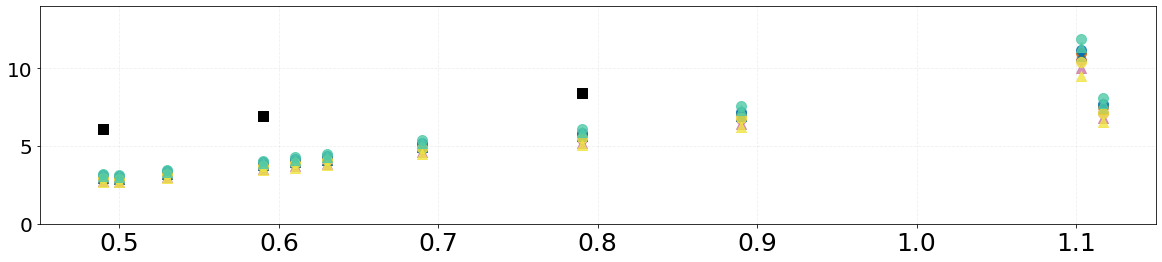

In [73]:
pc, dc = ds_filt(res_cc_global, d16a_cc_global, case="noAdaptation", cconly=True)
ds_minmax(pc, dc)
compPlot(
    ds2df(pc, dc),
    filename="global_npv_CC_noAdapt",
    xmin=0.45,
    xmax=1.15,
    ymin=0,
    ymax=14,
)

### Wetland Costs end-of-century

#### optimal, total

pyCIAM min: 22.684512 $Bn ('SLRProjections170113GRIDDEDcore_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 60.146471 $Bn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP1', 'OECD')
pyCIAM max: 193.12486 $Bn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'OECD')
Diaz 2016 min: 26.556726 $Bn rcp26_p50
Diaz 2016 med: 53.587094 $Bn rcp45_p50
Diaz 2016 max: 92.605617 $Bn rcp85_p50


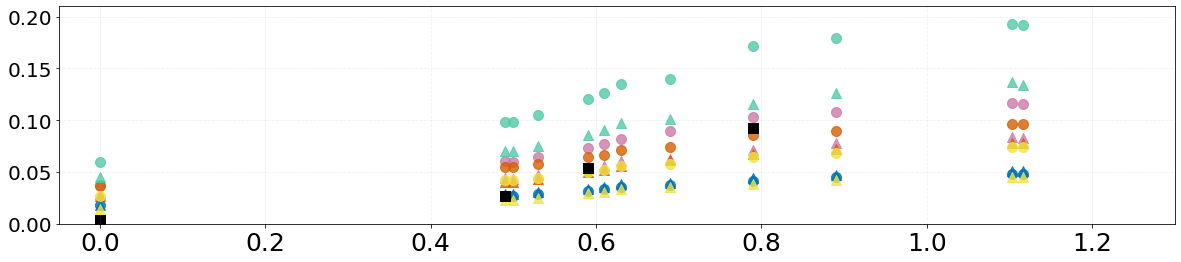

In [74]:
pc, dc = ds_filt(
    res_global,
    d16_global,
    val="costs",
    costtypes=["wetland"],
    year_min=RESENDYR,
    year_max=RESENDYR,
)
ds_minmax(pc, dc, val="costs", div=1e9, units="$Bn")
compPlot(ds2df(pc, dc), yval="costs", filename="wetlands_anncosts_total_opt", ymax=0.21)

#### optimal, CC-only 

pyCIAM min: 8.25077 $Bn ('SLRProjections170113GRIDDEDcore_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 30.102229 $Bn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP3', 'OECD')
pyCIAM max: 133.617615 $Bn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'OECD')
Diaz 2016 min: 22.569785 $Bn rcp26_p50
Diaz 2016 med: 49.600153 $Bn rcp45_p50
Diaz 2016 max: 88.618675 $Bn rcp85_p50


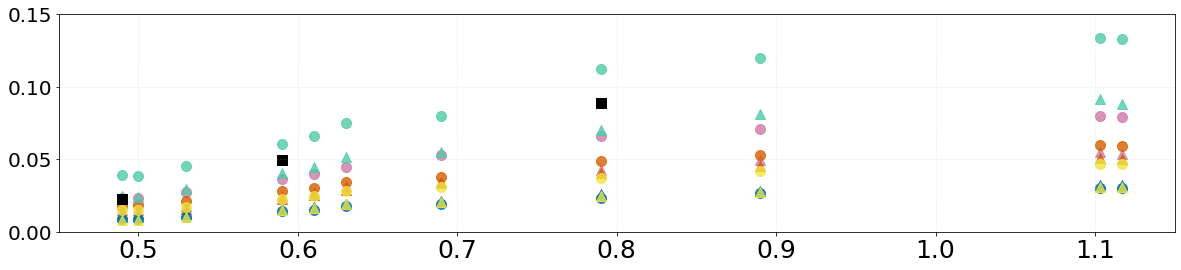

In [75]:
pc, dc = ds_filt(
    res_cc_global,
    d16a_cc_global,
    val="costs",
    costtypes=["wetland"],
    cconly=True,
    year_min=RESENDYR,
    year_max=RESENDYR,
)
ds_minmax(pc, dc, val="costs", div=1e9, units="$Bn")
compPlot(
    ds2df(pc, dc),
    yval="costs",
    filename="wetlands_anncosts_CC_opt",
    xmin=0.45,
    xmax=1.15,
    ymin=0,
    ymax=0.15,
)

### Global Costs end-of-century

#### optimal, total

pyCIAM min: 0.195628 $Tn ('SLRProjections170113GRIDDEDcore_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 0.422968 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP3', 'OECD')
pyCIAM max: 1.516572 $Tn ('SLRProjections200204GRIDDEDcore_D20_rcp85', 'SSP5', 'OECD')
Diaz 2016 min: 0.182086 $Tn rcp26_p50
Diaz 2016 med: 0.238437 $Tn rcp45_p50
Diaz 2016 max: 0.329423 $Tn rcp85_p50


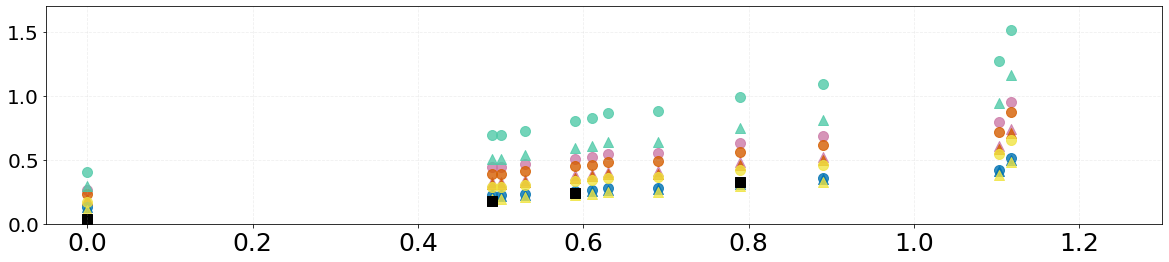

In [76]:
pc, dc = ds_filt(
    res_global, d16_global, val="costs", year_min=RESENDYR, year_max=RESENDYR
)
ds_minmax(pc, dc, val="costs")
compPlot(ds2df(pc, dc), yval="costs", filename="global_anncosts_total_opt", ymax=1.7)

#### optimal, CC-only 

pyCIAM min: 0.085268 $Tn ('SLRProjections170113GRIDDEDcore_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 0.217514 $Tn ('SLRProjections190726core_SEJ_full_2p0degree+L', 'SSP1', 'IIASA')
pyCIAM max: 1.109962 $Tn ('SLRProjections200204GRIDDEDcore_D20_rcp85', 'SSP5', 'OECD')
Diaz 2016 min: 0.146109 $Tn rcp26_p50
Diaz 2016 med: 0.20246 $Tn rcp45_p50
Diaz 2016 max: 0.293446 $Tn rcp85_p50


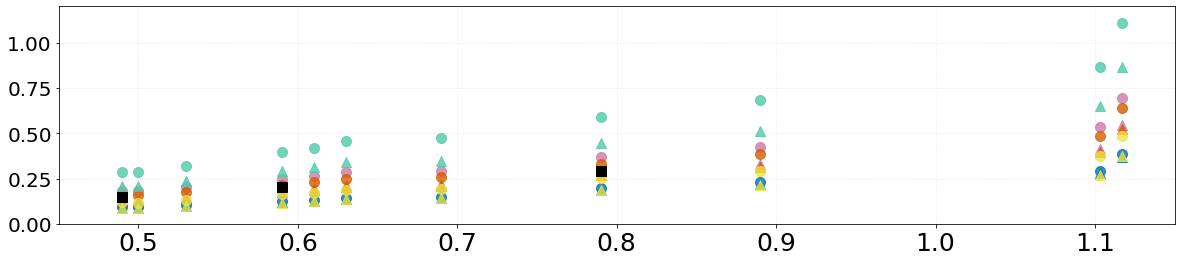

In [93]:
pc, dc = ds_filt(
    res_cc_global,
    d16a_cc_global,
    val="costs",
    cconly=True,
    year_min=RESENDYR,
    year_max=RESENDYR,
)
ds_minmax(pc, dc, val="costs")
compPlot(
    ds2df(pc, dc),
    yval="costs",
    filename="global_anncosts_CC_opt",
    xmin=0.45,
    xmax=1.15,
    ymin=0,
    ymax=1.2,
)

#### optimal, CC-only (simplifed)

pyCIAM min: 0.085268 $Tn ('SLRProjections170113GRIDDEDcore_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 0.213475 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp85', 'SSP4', 'IIASA')
pyCIAM max: 0.863267 $Tn ('SLRProjections200204GRIDDEDcore_D20_rcp85', 'SSP5', 'IIASA')
Diaz 2016 min: 0.146109 $Tn rcp26_p50
Diaz 2016 med: 0.20246 $Tn rcp45_p50
Diaz 2016 max: 0.293446 $Tn rcp85_p50


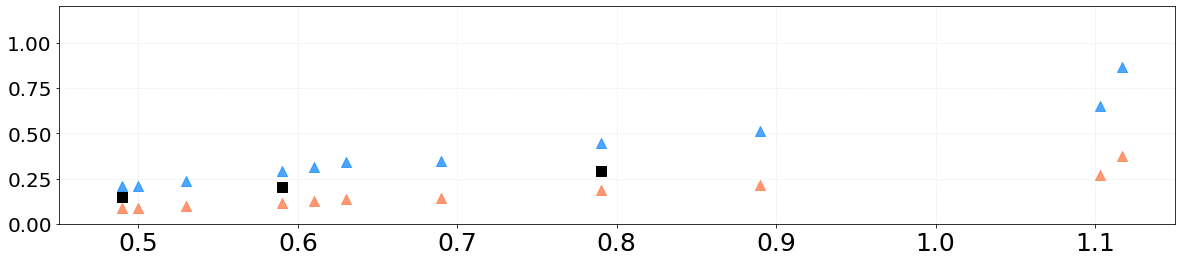

In [96]:
sel_ssps = ["SSP4", "SSP5"]
sel_iam = ["IIASA"]
pc_simple = pc.sel(ssp=sel_ssps, iam=sel_iam, drop=False)

ds_minmax(pc_simple, dc, val="costs")
compPlot(
    ds2df(pc_simple, dc),
    yval="costs",
    filename="global_anncosts_CC_opt_simplified",
    xmin=0.45,
    xmax=1.15,
    ymin=0,
    ymax=1.2,
    ssps=sel_ssps,
    iams=sel_iam,
    cvals=["coral", "dodgerblue"],
)

#### (pyCIAM K14) optimal, total range

In [97]:
df = ds2df(pc, dc)

print("pyCIAM K14 NPV min/med/max (no ncc)")
print(df[(df.model == "pyCIAM") & (df.rcp.isin(k14))].costs.min())
print(df[(df.model == "pyCIAM") & (df.rcp.isin(k14))].costs.median())
print(df[(df.model == "pyCIAM") & (df.rcp.isin(k14))].costs.max())
print("")

pyCIAM K14 NPV min/med/max (no ncc)
0.08526759594678879
0.18428751826286316
0.5869511365890503



#### noAdapt, total

pyCIAM min: 2.068917 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 3.870282 $Tn ('SLRProjections200204GRIDDEDcore_D20_rcp45', 'SSP2', 'OECD')
pyCIAM max: 12.543641 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'OECD')
Diaz 2016 min: 1.705881 $Tn rcp26_p50
Diaz 2016 med: 2.164304 $Tn rcp45_p50
Diaz 2016 max: 2.62945 $Tn rcp85_p50


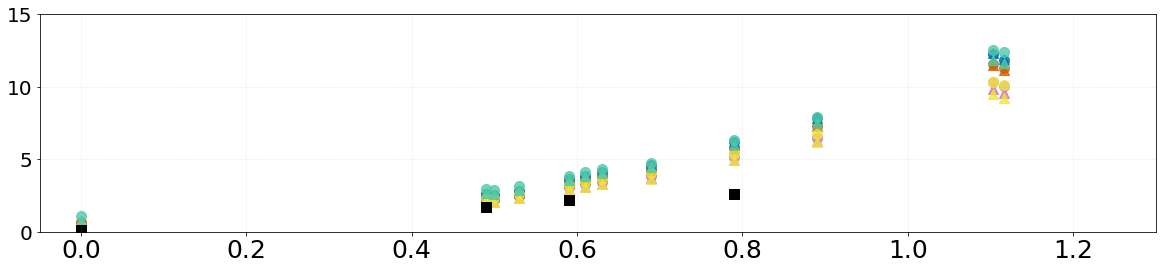

In [98]:
pc, dc = ds_filt(
    res_global,
    d16_global,
    case="noAdaptation",
    val="costs",
    year_min=RESENDYR,
    year_max=RESENDYR,
)
ds_minmax(pc, dc, val="costs")
compPlot(ds2df(pc, dc), yval="costs", filename="global_anncosts_total_noAdapt", ymax=15)

#### noAdapt, CC-only

pyCIAM min: 1.574253 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP1', 'OECD')
pyCIAM med: 3.309565 $Tn ('SLRProjections170113GRIDDEDcore_rcp45', 'SSP3', 'IIASA')
pyCIAM max: 12.026833 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP3', 'IIASA')
Diaz 2016 min: 1.577916 $Tn rcp26_p50
Diaz 2016 med: 2.036339 $Tn rcp45_p50
Diaz 2016 max: 2.501486 $Tn rcp85_p50


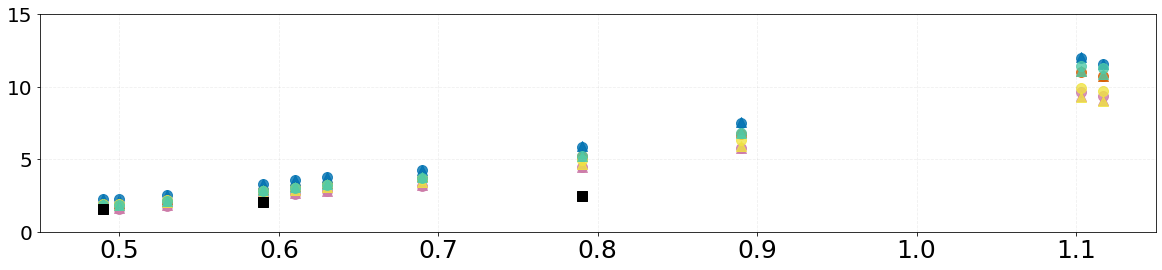

In [99]:
pc, dc = ds_filt(
    res_cc_global,
    d16a_cc_global,
    case="noAdaptation",
    val="costs",
    cconly=True,
    year_min=RESENDYR,
    year_max=RESENDYR,
)
ds_minmax(pc, dc, val="costs")
compPlot(
    ds2df(pc, dc),
    yval="costs",
    filename="global_anncosts_CC_noAdapt",
    xmin=0.45,
    xmax=1.15,
    ymin=0,
    ymax=15,
)

#### noAdapt, CC-only (simplified)

pyCIAM min: 1.830392 $Tn ('SLRProjections210628GRIDDEDcore_SROCC_rcp26', 'SSP4', 'IIASA')
pyCIAM med: 3.30042 $Tn ('SLRProjections200204GRIDDEDcore_D20_rcp45', 'SSP5', 'IIASA')
pyCIAM max: 11.120364 $Tn ('SLRProjections190726core_SEJ_full_rcp85+H', 'SSP5', 'IIASA')
Diaz 2016 min: 1.577916 $Tn rcp26_p50
Diaz 2016 med: 2.036339 $Tn rcp45_p50
Diaz 2016 max: 2.501486 $Tn rcp85_p50


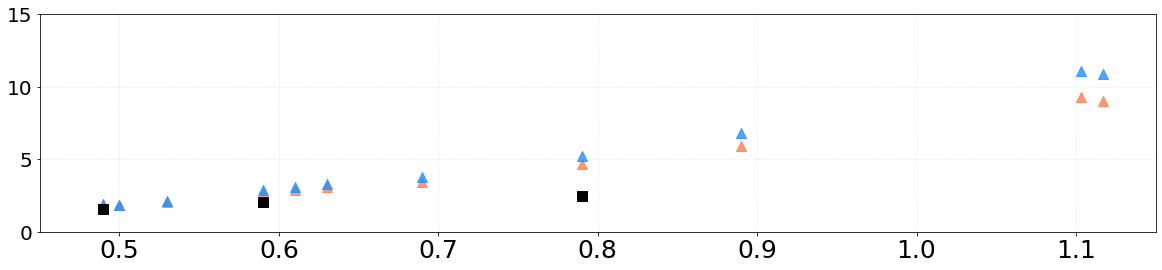

In [102]:
pc_simple = pc.sel(ssp=sel_ssps, iam=sel_iam, drop=False)

ds_minmax(pc_simple, dc, val="costs")
compPlot(
    ds2df(pc_simple, dc),
    yval="costs",
    filename="global_anncosts_CC_noAdapt_simplified",
    xmin=0.45,
    xmax=1.15,
    ymin=0,
    ymax=15,
    ssps=sel_ssps,
    iams=sel_iam,
    cvals=["coral", "dodgerblue"],
)

### Optimal Retreat Strategy

In [103]:
MAXELEV = (
    15  # max elev in Diaz, and max to consider in % pop and length comparisons w pyCIAM
)
pyCIAM_elevs = [e for e in inputs.elev.values if e <= MAXELEV]
# Get seg (Diaz) population and coastline length totals
seg_pop = (
    (d16inputs.pop_2000.sum("elev") * d16inputs.pop_scale.sel(year=POPWTYR))
    .rename("pop")
    .to_dataset()
)

seg_len = d16inputs.length.to_dataset()

# Get seg_adm (pyCIAM) population and coastline length totals
a = (
    inputs.sel(elev=pyCIAM_elevs)
    .pop_2019.sum("elev")
    .to_dataframe()
    .reset_index()
    .rename(columns={"seg_country": "country"})
)
b = inputs.pop_scale.sel(year=POPWTYR).to_dataframe().reset_index()
c = a.merge(b)
c["pop"] = c.pop_2019 * c.pop_scale
seg_adm_pop = c.set_index(["seg_adm", "ssp", "iam"])["pop"].to_xarray()
seg_adm_len = inputs.length.to_dataset()

In [104]:
# Get dataframes of optimal strategy by scenario for Diaz config
dc = (
    d16a.sel(rcp_pt=DIAZSCENS)
    .optimal_case.to_dataset()
    .merge(seg_pop)
    .merge(seg_len)[["optimal_case", "pop", "length"]]
    .persist()
)

dtpop = dc["pop"].sum("seg").values
dtlen = dc.length.sum().values

dcdf = (
    dc.to_dataframe()
    .set_index("optimal_case", append=True)
    .groupby(["optimal_case", "rcp_pt"])
    .sum()
    .drop(columns="year")
    .reset_index()
)

# Get dataframes of optimal strategy by scenario for pyCIAM
pc = (
    res.optimal_case.to_dataset()
    .merge(seg_adm_pop)
    .merge(seg_adm_len)[["optimal_case", "pop", "length"]]
    .persist()
)

ptpop = (
    pc["pop"]
    .sum("seg_adm")
    .to_dataframe()
    .reset_index()
    .rename(columns={"pop": "tpop"})
)
ptlen = pc.length.sum().values

pcdf = (
    pc.to_dataframe()
    .set_index("optimal_case", append=True)
    .groupby(["optimal_case", "scenario", "ssp", "iam"])
    .sum()
    .reset_index()
)

# Add columns to Diaz16 df for concat with pyCIAM df
dcdf["rcp"] = [v.split("_")[0] for v in dcdf.rcp_pt]
dcdf.loc[dcdf.rcp == "rcp0", "rcp"] = "ncc"
dcdf = dcdf.drop(columns="rcp_pt")

dcdf["ssp"] = np.nan
dcdf["iam"] = np.nan
dcdf["model"] = "diaz"
dcdf["tpop"] = dtpop
dcdf["tlen"] = dtlen

# Add columns to pyCIAM df for concat with Diaz16 df
pcdf = pcdf.rename(columns={"scenario": "rcp"})
pcdf["model"] = "pyCIAM"
pcdf = pcdf.merge(ptpop, "left", ["ssp", "iam"])
pcdf["tlen"] = ptlen

In [105]:
# Join pyCIAM and Diaz16 optimal retreat strategy dataframes
odf = pd.concat([dcdf, pcdf])

odf["pct_pop"] = (odf["pop"] / odf.tpop) * 100
odf["pct_len"] = (odf["length"] / odf.tlen) * 100

odf.loc[odf.ssp.isnull(), "ssp"] = "diaz"
odf.loc[odf.iam.isnull(), "iam"] = "diaz"

odf["action"] = np.nan
odf.loc[odf.optimal_case == 0, "action"] = "noAdapt"

odf.loc[odf.optimal_case.isin([1, 2, 3, 4]), "action"] = "protect"
odf.loc[odf.optimal_case.isin([5, 6, 7, 8, 9]), "action"] = "retreat"

# Separate optimal df by noAdapt, protect, retreat for plotting
noadapt = odf[odf.action == "noAdapt"].merge(gmsl)

protect = (
    odf[odf.action == "protect"]
    .groupby(["rcp", "ssp", "iam", "model"])
    .sum()
    .reset_index()
).merge(gmsl)

retreat = (
    odf[odf.action == "retreat"]
    .groupby(["rcp", "ssp", "iam", "model"])
    .sum()
    .reset_index()
).merge(gmsl)

#### % Population

##### Protect

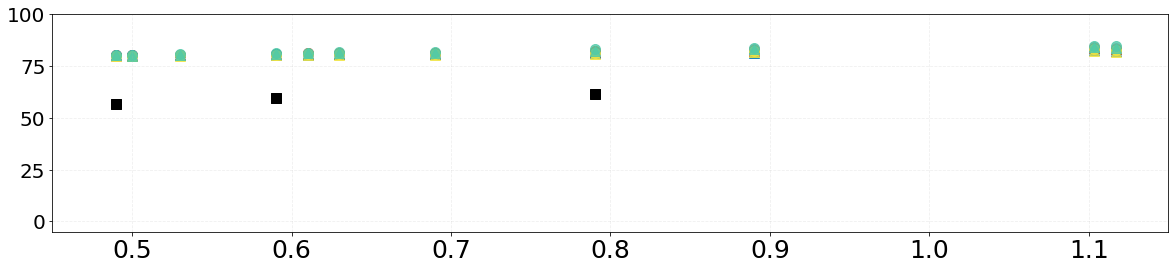

In [106]:
compPlot(
    protect,
    "pct_pop",
    filename="optcase_protect_pop",
    xmin=0.45,
    xmax=1.15,
    ymin=-5,
    ymax=100,
)

##### Retreat

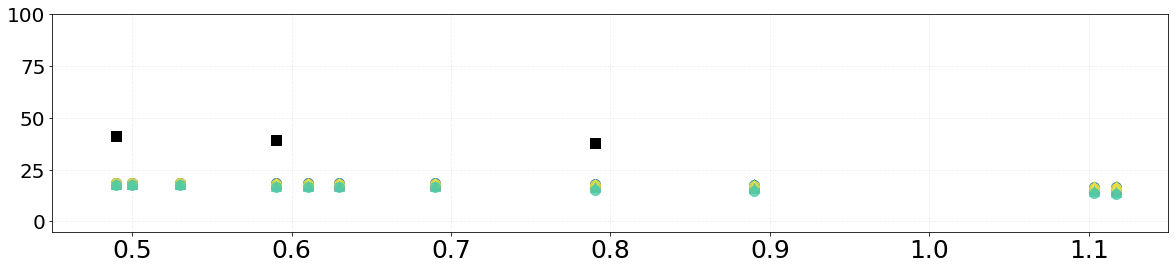

In [107]:
compPlot(
    retreat,
    "pct_pop",
    filename="optcase_retreat_pop",
    xmin=0.45,
    xmax=1.15,
    ymin=-5,
    ymax=100,
)

##### No Adapt

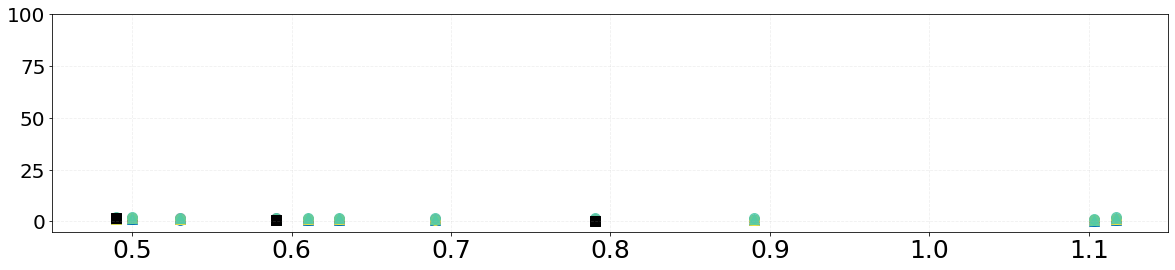

In [108]:
compPlot(
    noadapt,
    "pct_pop",
    filename="optcase_noAdapt_pop",
    xmin=0.45,
    xmax=1.15,
    ymin=-5,
    ymax=100,
)

#### % Length

##### Protect

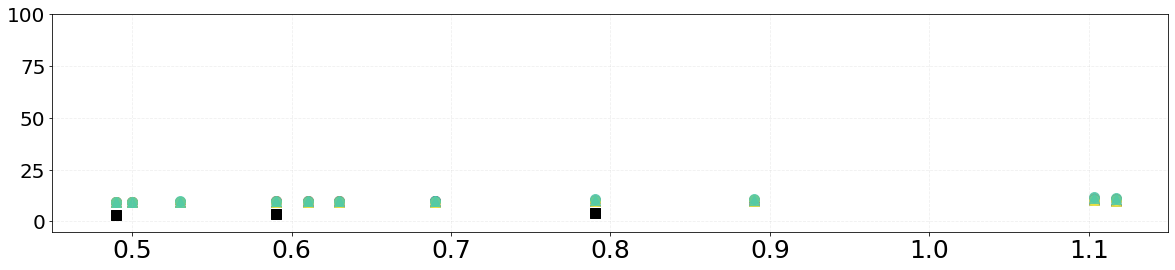

In [109]:
compPlot(
    protect,
    "pct_len",
    filename="optcase_protect_len",
    xmin=0.45,
    xmax=1.15,
    ymin=-5,
    ymax=100,
)

##### Retreat

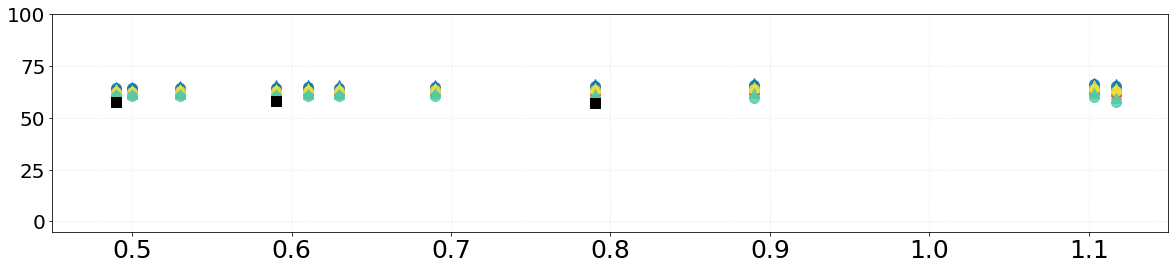

In [110]:
compPlot(
    retreat,
    "pct_len",
    filename="optcase_retreat_len",
    xmin=0.45,
    xmax=1.15,
    ymin=-5,
    ymax=100,
)

##### No Adapt

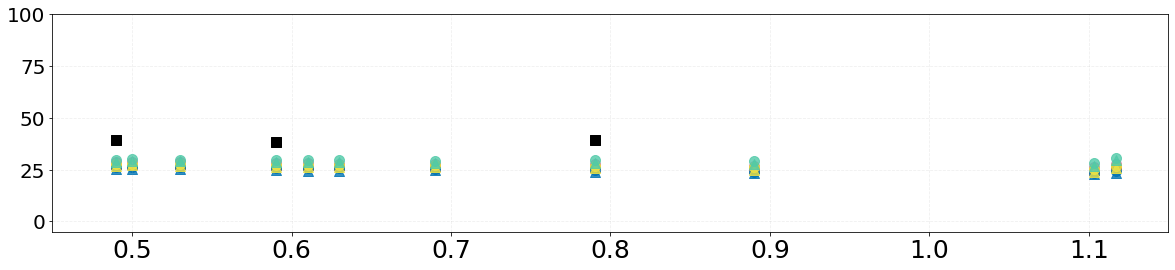

In [111]:
compPlot(
    noadapt,
    "pct_len",
    filename="optcase_noAdapt_len",
    xmin=0.45,
    xmax=1.15,
    ymin=-5,
    ymax=100,
)

## Prepare Data for Plotting

### Compute Median Costs in 2100

In [119]:
res = res.sel(
    ssp=ssp,
    iam=iam,
    scenario=["ncc", scen],
    case=["noAdaptation", "optimalfixed"],
    drop=True,
).load()

In [112]:
# If results represent median, add "scen_mc" dimension to be compatible with multi lslr draw structure
if MEDRESULTS:
    res = res.sel(ssp=ssp, iam=iam, scenario=["ncc", scen], drop=True)
    med_scen_mc_ncc = 0
    med_scen_mc = 1

    res = res.rename({"scenario": "scen_mc"})
    res["scen_mc"] = [0, 1]

    res = res.sel(case=["noAdaptation", "optimalfixed"]).rename({"case": "adapt_type"})
    res["adapt_type"] = ["noAdapt", "optimal"]

    res = res.load()

In [176]:
# Create pyCIAM costs dataframe to join to adm1 and country shapefiles for global maps
cost_df = pd.DataFrame(index=res.seg_adm.values)
cost_df.index.name = "seg_adm"
for at in ["optimalfixed", "noAdaptation"]:
    for msmc, suffix in [(scen, ""), ("ncc", "_ncc")]:
        csfx = "costs_2100_med_" + at + suffix  # join column name suffix

        # Total Median 2100 Costs
        cmed = (
            res.costs.sel(scenario=msmc, year=RESENDYR, case=at, drop=True)
            .sum("costtype")
            .to_dataframe()
            .rename(columns={"costs": csfx})
        )
        cost_df = cost_df.join(cmed)

        # Individual cost types
        for c in COSTTYPES:
            ctmed = (
                res.costs.sel(
                    scenario=msmc, year=RESENDYR, costtype=c, case=at, drop=True
                )
                .to_dataframe()["costs"]
                .rename(c + "_" + csfx)
            )
            cost_df = cost_df.join(ctmed)

    # Save CC and no CC diff
    cost_df["costs_2100_med_" + at + "_diff"] = (
        cost_df["costs_2100_med_" + at] - cost_df["costs_2100_med_" + at + "_ncc"]
    )

    for c in COSTTYPES:
        cost_df[c + "_" + "costs_2100_med_" + at + "_diff"] = (
            cost_df[c + "_" + "costs_2100_med_" + at]
            - cost_df[c + "_" + "costs_2100_med_" + at + "_ncc"]
        )

# Join seg_adm population
cost_df = cost_df.join(seg_adm_pop.sel(ssp=ssp, iam=iam, drop=True).to_dataframe())

# Join seg_adm gdp (ypcc * pop)
a = (
    inputs.seg_country.to_dataframe()["seg_country"]
    .iloc[:, 0:1]
    .rename(columns={"seg_country": "country"})
    .reset_index()
)
b = (
    inputs.ypcc.sel(ssp=ssp, iam=iam, year=RESENDYR, drop=True)
    .to_dataframe()
    .reset_index()
)
seg_adm_ypcc = a.merge(b, "left", "country").set_index("seg_adm")
cost_df = cost_df.join(seg_adm_ypcc)
cost_df["gdp"] = cost_df["pop"] * cost_df["ypcc"]

### Create Scaled Variables for Plotting

In [177]:
# Calculate various possible variables for plotting (log transformed, % of population, % of GDP etc.)
# Not all are used in plots below
sers = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    for cc in ["", "ncc", "diff"]:
        for at in ["optimalfixed", "noAdaptation"]:
            # log total costs (log-$USD)
            cost_df["_".join(["costs_2100_med_log", at, cc]).strip("_")] = fillinf(
                np.log(cost_df["_".join(["costs_2100_med", at, cc]).strip("_")])
            )

            # per capita median costs in 2100 (and log)
            cost_df["_".join(["costs_percap", at, cc]).strip("_")] = fillnan(
                cost_df["_".join(["costs_2100_med", at, cc]).strip("_")]
                / cost_df["pop"]
            )  # annual $USD/person
            cost_df["_".join(["costs_percap_log", at, cc]).strip("_")] = fillinf(
                np.log(cost_df["_".join(["costs_percap", at, cc]).strip("_")])
            )

            # % GDP median costs in 2100
            cost_df["_".join(["costs_pctgdp", at, cc]).strip("_")] = fillnan(
                100
                * cost_df["_".join(["costs_2100_med", at, cc]).strip("_")]
                / cost_df.gdp
            )  # annual $USD/person
            cost_df["_".join(["costs_pctgdp_log", at, cc]).strip("_")] = fillinf(
                np.log(cost_df["_".join(["costs_pctgdp", at, cc]).strip("_")])
            )

            # by indivdual costtype
            for c in COSTTYPES:
                sers.append(
                    (
                        "_".join([c, "costs_percap", at, cc]).strip("_"),
                        fillnan(
                            cost_df["_".join([c, "costs_2100_med", at, cc]).strip("_")]
                            / cost_df["pop"]
                        ),
                    )
                )

                pctgdp = fillnan(
                    100
                    * cost_df["_".join([c, "costs_2100_med", at, cc]).strip("_")]
                    / cost_df.gdp
                )
                sers.append(("_".join([c, "costs_pctgdp", at, cc]).strip("_"), pctgdp))
                sers.append(
                    (
                        "_".join([c, "costs_pctgdp_log", at, cc]).strip("_"),
                        fillinf(np.log(pctgdp)),
                    )
                )

    cost_df = cost_df.join(pd.DataFrame.from_dict(dict(sers)))

    # Adaptation Benefits (optimal compared to noAdapt)
    cost_df["costs_2100_med_benAdaptation"] = (
        cost_df.costs_2100_med_noAdaptation - cost_df.costs_2100_med_optimalfixed
    )
    cost_df["costs_2100_med_log_benAdaptation"] = fillinf(
        np.log(cost_df.costs_2100_med_benAdaptation)
    )

### Import SHPs for Maps, Join Results

In [230]:
# ADM1
adm1 = (
    gpd.read_file(PATH_GADM_1)
    .rename(columns={"GID_1": "adm1", "GID_0": "country"})
    .set_index("adm1")[["country", "NAME_0", "geometry"]]
)

# Country
ctys = (
    gpd.read_file(PATH_GADM_0).rename(columns={"GID_0": "country"}).set_index("country")
)

# Add single adm1 countries (e.g. Aruba) to adm1 file
cost_df["adm1"] = [i.split("adm1_")[1] for i in cost_df.index.values]
adm1_ctys = [i for i in list(set(cost_df.adm1)) if i in list(ctys.index.values)]
adm1_ctys = ctys.loc[adm1_ctys].reset_index()
adm1_ctys["adm1"] = adm1_ctys.country
adm1_ctys = adm1_ctys.set_index("adm1")
adm1 = adm1.append(adm1_ctys)

# Join costs to adm1 and country SHPs
adm1 = adm1.join(cost_df.groupby("adm1").sum())
ctys = ctys.join(cost_df.groupby("country").sum())

# Import borders and coastlines SHPs
borders = gpd.read_file(PATH_BORDERS)
clines = gpd.read_file(PATH_COASTLINES).set_crs(epsg=4326)

### Plotting Functions

In [231]:
# CIL Color Map (Reds)
colors = [
    "#fff3d7",
    "#fbc885",
    "#f39b65",
    "#ea744b",
    "#e45d3d",
    "#db4231",
    "#d51d26",
]
cil_cmap = LinearSegmentedColormap.from_list("mycm", colors, N=100)


def costs_pt_plot(
    ptshp,
    bbox,
    val_col="costs_percap",
    title_main="Median Per Capita Total Damages in 2099 [$USD 2019]",
    title_sub=f"\n({ssp}, RCP8.5)",
    vmin=0,
    vmax=300,
    cm=cil_cmap,
    symlog=True,
    linthresh=1,
    linscale=1,
    plotneg=False,
    negcmap="Reds_r",
    neg_vmin=-1,
    neg_vmax=0,
):

    fig, ax = plt.subplots(1, 1, frameon=False)
    fig.set_figheight(20)
    fig.set_figwidth(40)
    title_name = title_main
    title_name += title_sub
    ax.set_title(
        title_name,
        fontsize=18,
        loc="left",
        fontweight="bold",
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    # International Borders
    borders.to_crs("ESRI:54030").plot(
        ax=ax, facecolor="none", edgecolor="#808080", linewidth=1, alpha=0.5, zorder=5
    )

    # Coastlines
    clines.to_crs("ESRI:54030").plot(
        ax=ax, edgecolor="#808080", linewidth=1, alpha=0.5, zorder=0
    )

    if symlog:
        ptshp.sort_values(val_col).cx[
            bbox["xmin"] : bbox["xmax"], bbox["ymin"] : bbox["ymax"]
        ].to_crs("ESRI:54030").plot(
            column=val_col,
            ax=ax,
            legend=True,
            cmap=cm,
            norm=mcols.SymLogNorm(linthresh, linscale=linscale, vmin=vmin, vmax=vmax),
            markersize=120,
            edgecolor="#808080",
            linewidth=0,
            alpha=0.8,
            zorder=10,
        )
    else:
        ptshp.sort_values(val_col).cx[
            bbox["xmin"] : bbox["xmax"], bbox["ymin"] : bbox["ymax"]
        ].to_crs("ESRI:54030").plot(
            column=val_col,
            ax=ax,
            legend=True,
            cmap=cm,
            vmin=vmin,
            vmax=vmax,
            markersize=120,
            edgecolor="#808080",
            linewidth=0,
            alpha=0.8,
            zorder=10,
        )

    if plotneg:
        ptshp[ptshp[val_col] < 0].sort_values(val_col).cx[
            bbox["xmin"] : bbox["xmax"], bbox["ymin"] : bbox["ymax"]
        ].to_crs("ESRI:54030").plot(
            column=val_col,
            ax=ax,
            legend=True,
            cmap=negcmap,
            vmin=neg_vmin,
            vmax=neg_vmax,
            markersize=120,
            edgecolor="#808080",
            linewidth=0,
            alpha=0.8,
            zorder=11,
        )

    fig.show()


# Plot Polygons (e.g. IR polys, ADM1 polys etc.)
def costs_poly_plot(
    polyshp,
    bbox,
    val_col="costs_percap",
    title_main="Median Damages in 2100 [log % National GDP]",
    title_sub=f"\n({ssp}, RCP8.5)",
    filename="mymap",
    vmin=0,
    vmax=1,
    cm=cil_cmap,
    symlog=True,
    linthresh=1,
    linscale=1,
):
    """creates map of results values for given scenario for geographic boundaries (e.g. national, ADM1)

    ----------
    polyshp : gdp.GeoDataFrame
        gdf with joined results variables of polygons to plot (e.g. national or ADM1 boundaries)
    bbox : dict
        lat/lon bounding box for plotting (e.g. {"xmin": -180, "xmax": 180, "ymin": -90, "ymax": 90})
    val_col : str
        name of variable to plot
    title_main : str
        map title to display
    title_sub : str
        map subtitle to display
    filename : str
        name of saved map file .png
    vmin, vmax : int or float
        range of color scale variable (z values) on map
    cm : int
        color map for plot
    symlog : True/False
        enable symmetric log for color scale?
    linthresh : int or float
        The range within which the plot is linear
    linscale : int or float
        This allows the linear range to be stretched relative to the logarithmic range.

    """
    fig, ax = plt.subplots(1, 1, frameon=False)
    fig.set_figheight(20)
    fig.set_figwidth(40)
    title_name = title_main
    title_name += title_sub
    ax.set_title(
        title_name,
        fontsize=18,
        loc="left",
        fontweight="bold",
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    if symlog:
        polyshp.cx[bbox["xmin"] : bbox["xmax"], bbox["ymin"] : bbox["ymax"]].to_crs(
            "ESRI:54030"
        ).plot(
            column=val_col,
            ax=ax,
            legend=True,
            cmap=cm,
            norm=mcols.SymLogNorm(linthresh, linscale=linscale, vmin=vmin, vmax=vmax),
            vmin=vmin,
            vmax=vmax,
            edgecolor="#ffffff",
            linewidth=0.1,
            zorder=10,
        )
    else:
        polyshp.cx[bbox["xmin"] : bbox["xmax"], bbox["ymin"] : bbox["ymax"]].to_crs(
            "ESRI:54030"
        ).plot(
            column=val_col,
            ax=ax,
            legend=True,
            cmap=cm,
            vmin=vmin,
            vmax=vmax,
            edgecolor="#ffffff",
            linewidth=0.1,
            zorder=10,
        )

    plt.savefig(DIR_FIGS / str(filename + ".png"))

### Define which variables to save & Apply Manual Region Removals for Plots (country and ADM1)

In [200]:
# ADM1
# Replace 0s with NaN for no cost adm1 regions
adm1 = adm1[
    [
        "country",
        "costs_2100_med_optimalfixed_diff",
        "costs_2100_med_benAdaptation",
        "geometry",
    ]
]
adm1.columns = ["country", "costs", "benAdapt", "geometry"]

# Manual removals of adm1 for maps
adm1_rem = [
    "USA.46",
    "USA.18",
    "MEX.24",
    "GTM.12",
    "HND.18",
    "CRI.1",
    "PAN.6",
    "COL.11",
    "VEN.20",
    "BRA.23",
    "BRA.4",
    "PRY.4",
    "ARG.9",
    "ARG.7",
    "VEN.6",
    "PER.7",
    "CHN.1",
    "CHN.11",
    "CHN.12",
    "CHN.13",
    "CHN.14",
    "CHN.16",
    "CHN.17",
    "IND.4",
    "SEN.9",
    "SEN.7",
    "MRT.3",
    "ITA.10",
    "POL.1",
    "POL.4",
    "FRA.11",
    "SWE.17",
    "SWE.2",
    "RUS.5",
    "RUS.10",
    "RUS.18",
    "RUS.15",
    "RUS.22",
    "RUS.54",
    "RUS.42",
    "RUS.9",
    "RUS.12",
    "RUS.30",
    "RUS.36",
    "RUS.32",
    "RUS.33",
    "RUS.71",
    "RUS.62",
    "RUS.63",
    "RUS.65",
    "RUS.69",
    "RUS.77",
    "RUS.79",
    "RUS.40",
    "RUS.8",
    "KAZ.2",
    "KAZ.3",
    "KAZ.4",
    "KAZ.6",
    "KAZ.8",
    "KAZ.10",
    "KAZ.11",
    "KAZ.13",
    "UKR.18",
    "UKR.13",
    "BLR.1",
    "AZE.1",
    "AZE.2",
    "AZE.3",
    "AZE.6",
    "AZE.8",
    "UZB.5",
    "UZB.9",
    "TKM.3",
    "TKM.6",
    "IRN.2",
    "IRN.8",
    "IRN.9",
    "IRN.20",
]
adm1_rem = [i + "_1" for i in adm1_rem]
adm1.loc[adm1_rem, ["costs", "benAdaptation"]] = np.nan  # set to NaN

# Countrys
ctys = ctys[
    [
        "NAME_0",
        "costs_2100_med_optimalfixed_diff",
        "costs_2100_med_benAdaptation",
        "geometry",
    ]
]
ctys.columns = ["name", "costs", "benAdaptation", "geometry"]

# Manual Removals
ctys.loc[["PRY", "KAZ", "SRB", "LAO"], ["costs", "benAdaptation"]] = np.nan

# Define global bounding box
bb = {"xmin": -180, "xmax": 180, "ymin": -90, "ymax": 90}

## Generate Plots

### Country Plots

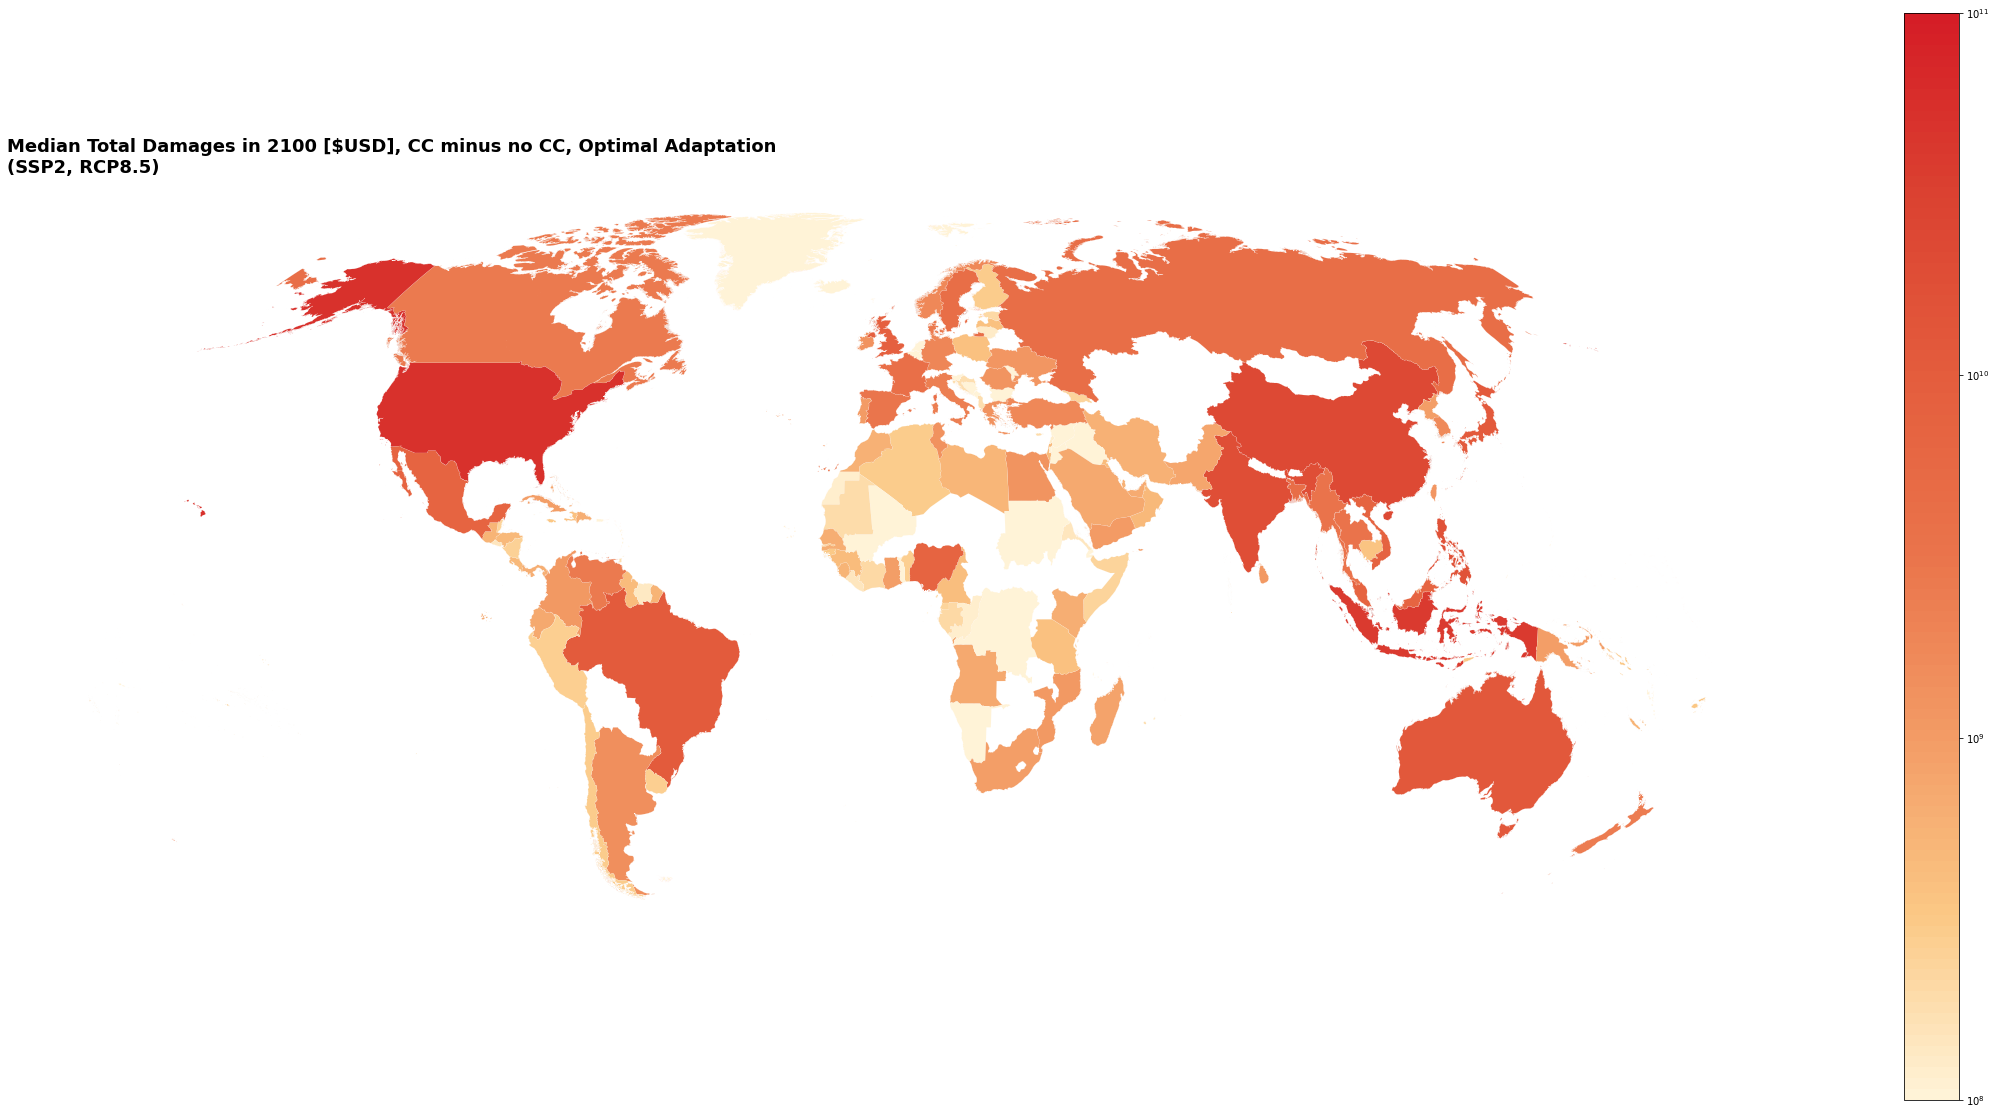

In [201]:
# Total Costs in 2100 (USD)
costs_poly_plot(
    ctys,
    bb,
    "costs",
    filename="map_country_global_costs_CC_opt",
    title_main="Median Total Damages in 2100 [$USD], CC minus no CC, Optimal Adaptation",
    vmin=1e8,
    vmax=1e11,
)

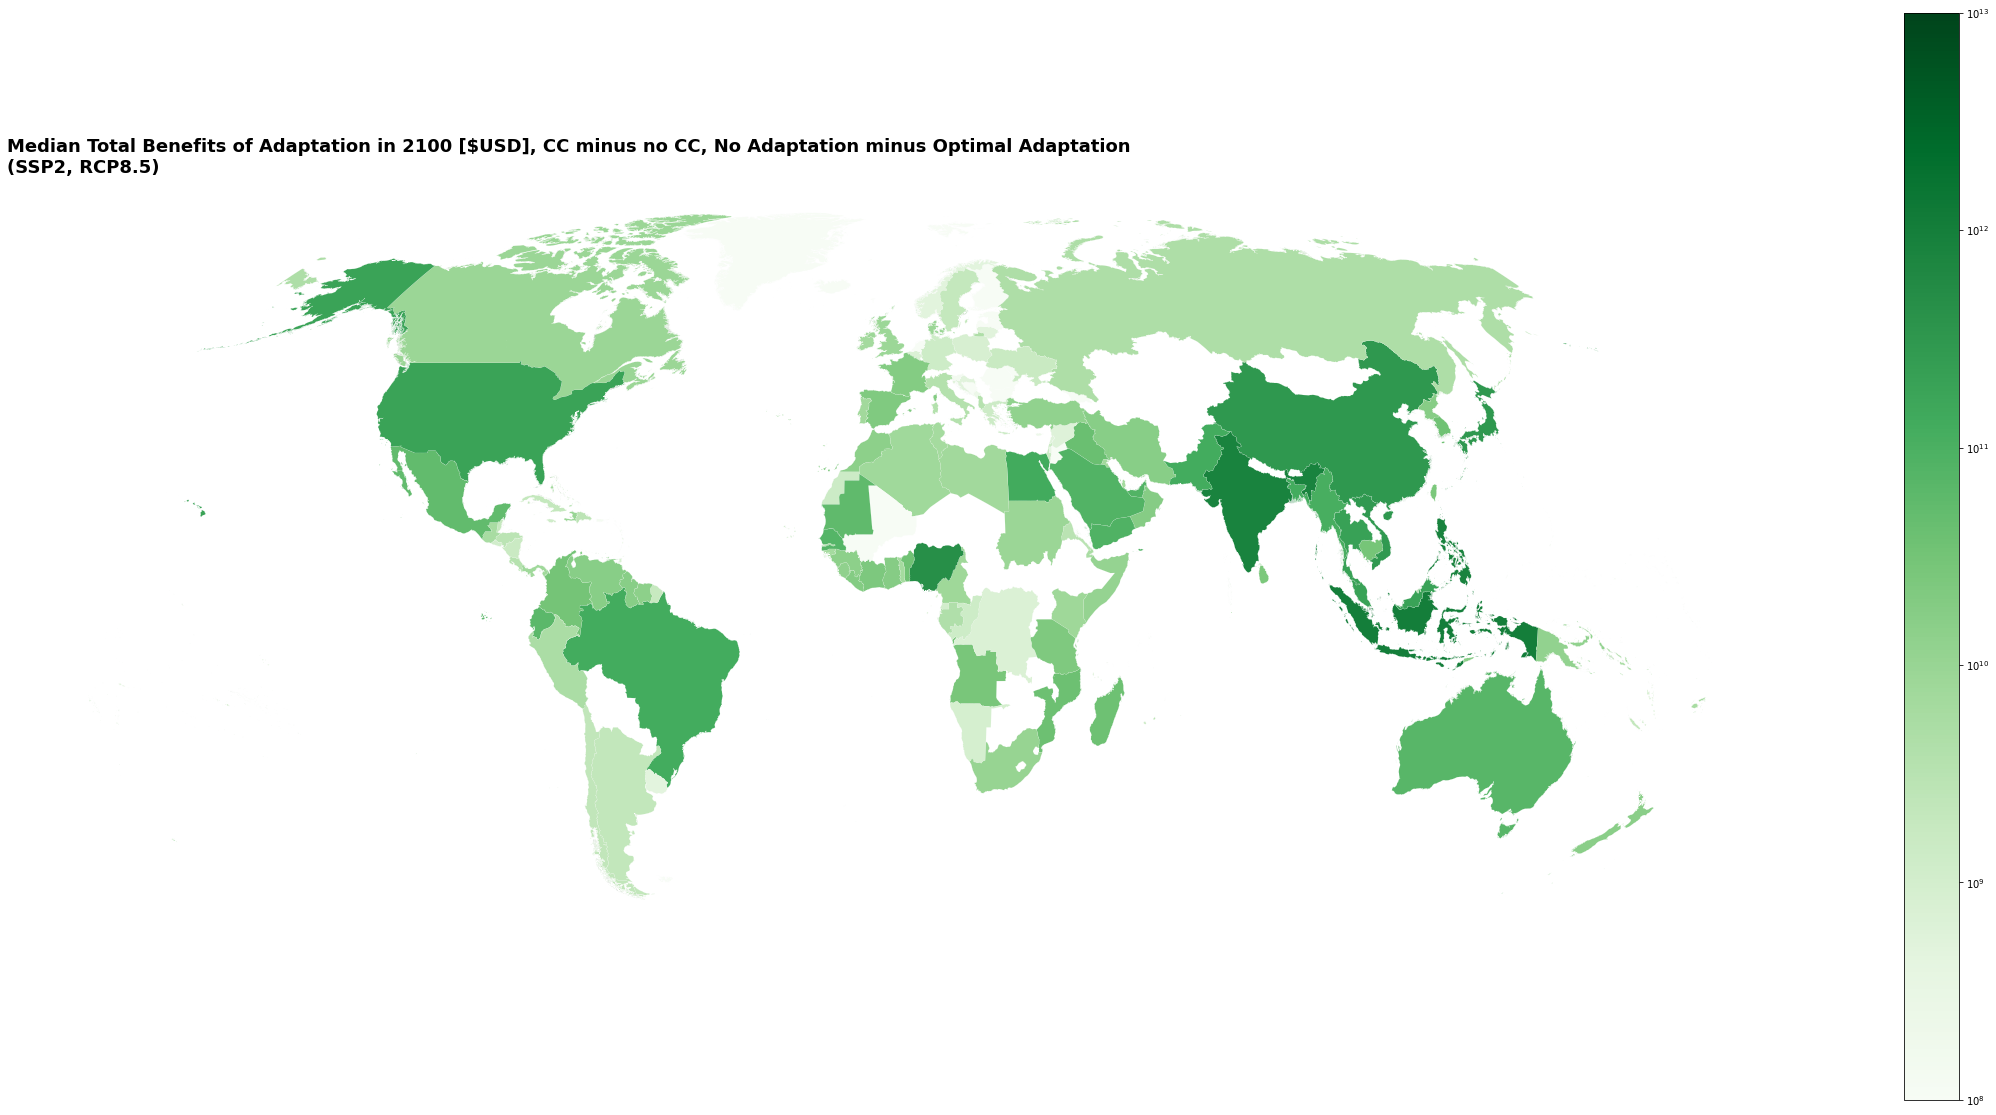

In [202]:
# Benefits of Adaptation in 2100 [USD]
costs_poly_plot(
    ctys,
    bb,
    "benAdaptation",
    filename="map_country_global_benAdapt_CC_opt",
    title_main="Median Total Benefits of Adaptation in 2100 [$USD], CC minus no CC, No Adaptation minus Optimal Adaptation",
    vmin=1e8,
    vmax=1e13,
    cm="Greens",
)

### ADM1 Plots

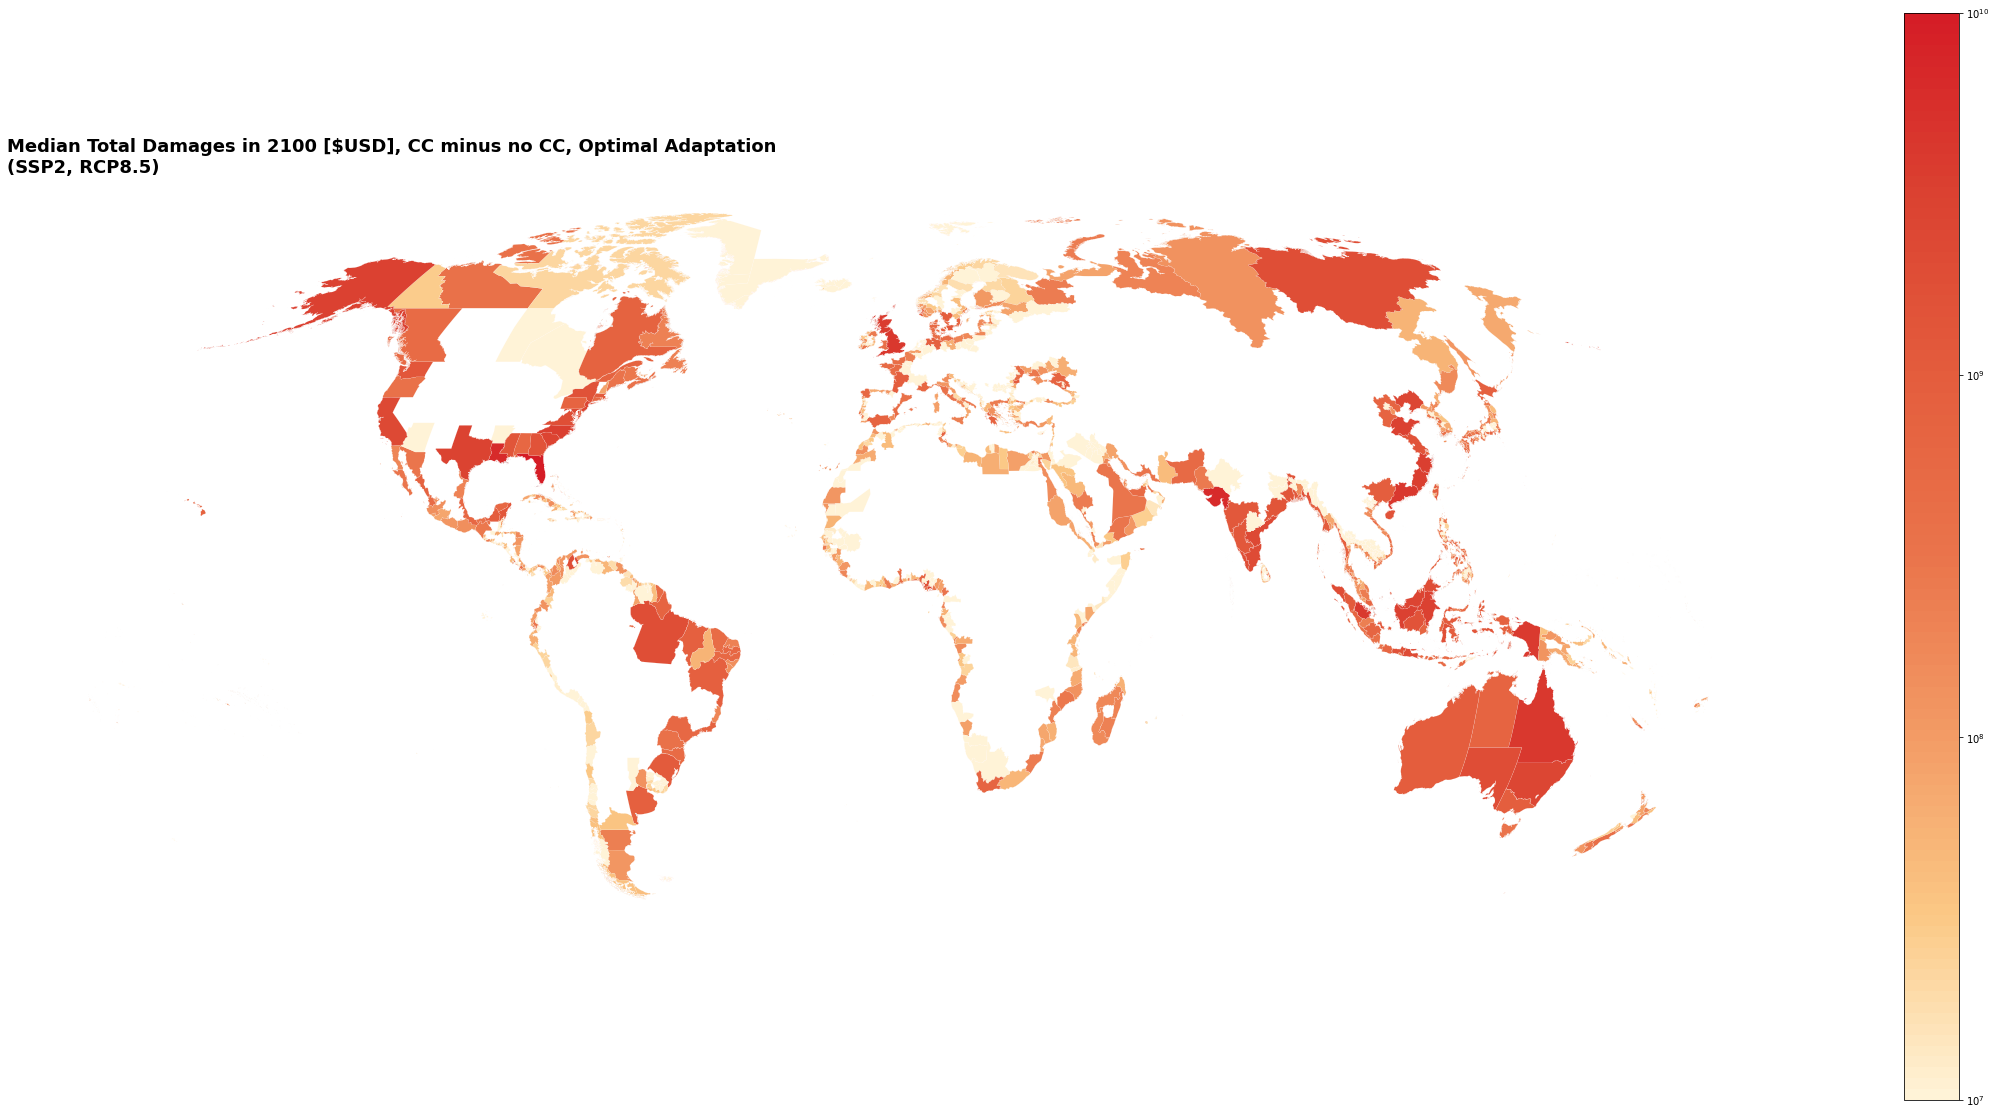

In [203]:
# Total Costs in 2100 (USD)
costs_poly_plot(
    adm1,
    bb,
    "costs",
    filename="map_adm1_global_costs_CC_opt",
    title_main="Median Total Damages in 2100 [$USD], CC minus no CC, Optimal Adaptation",
    vmin=1e7,
    vmax=1e10,
)

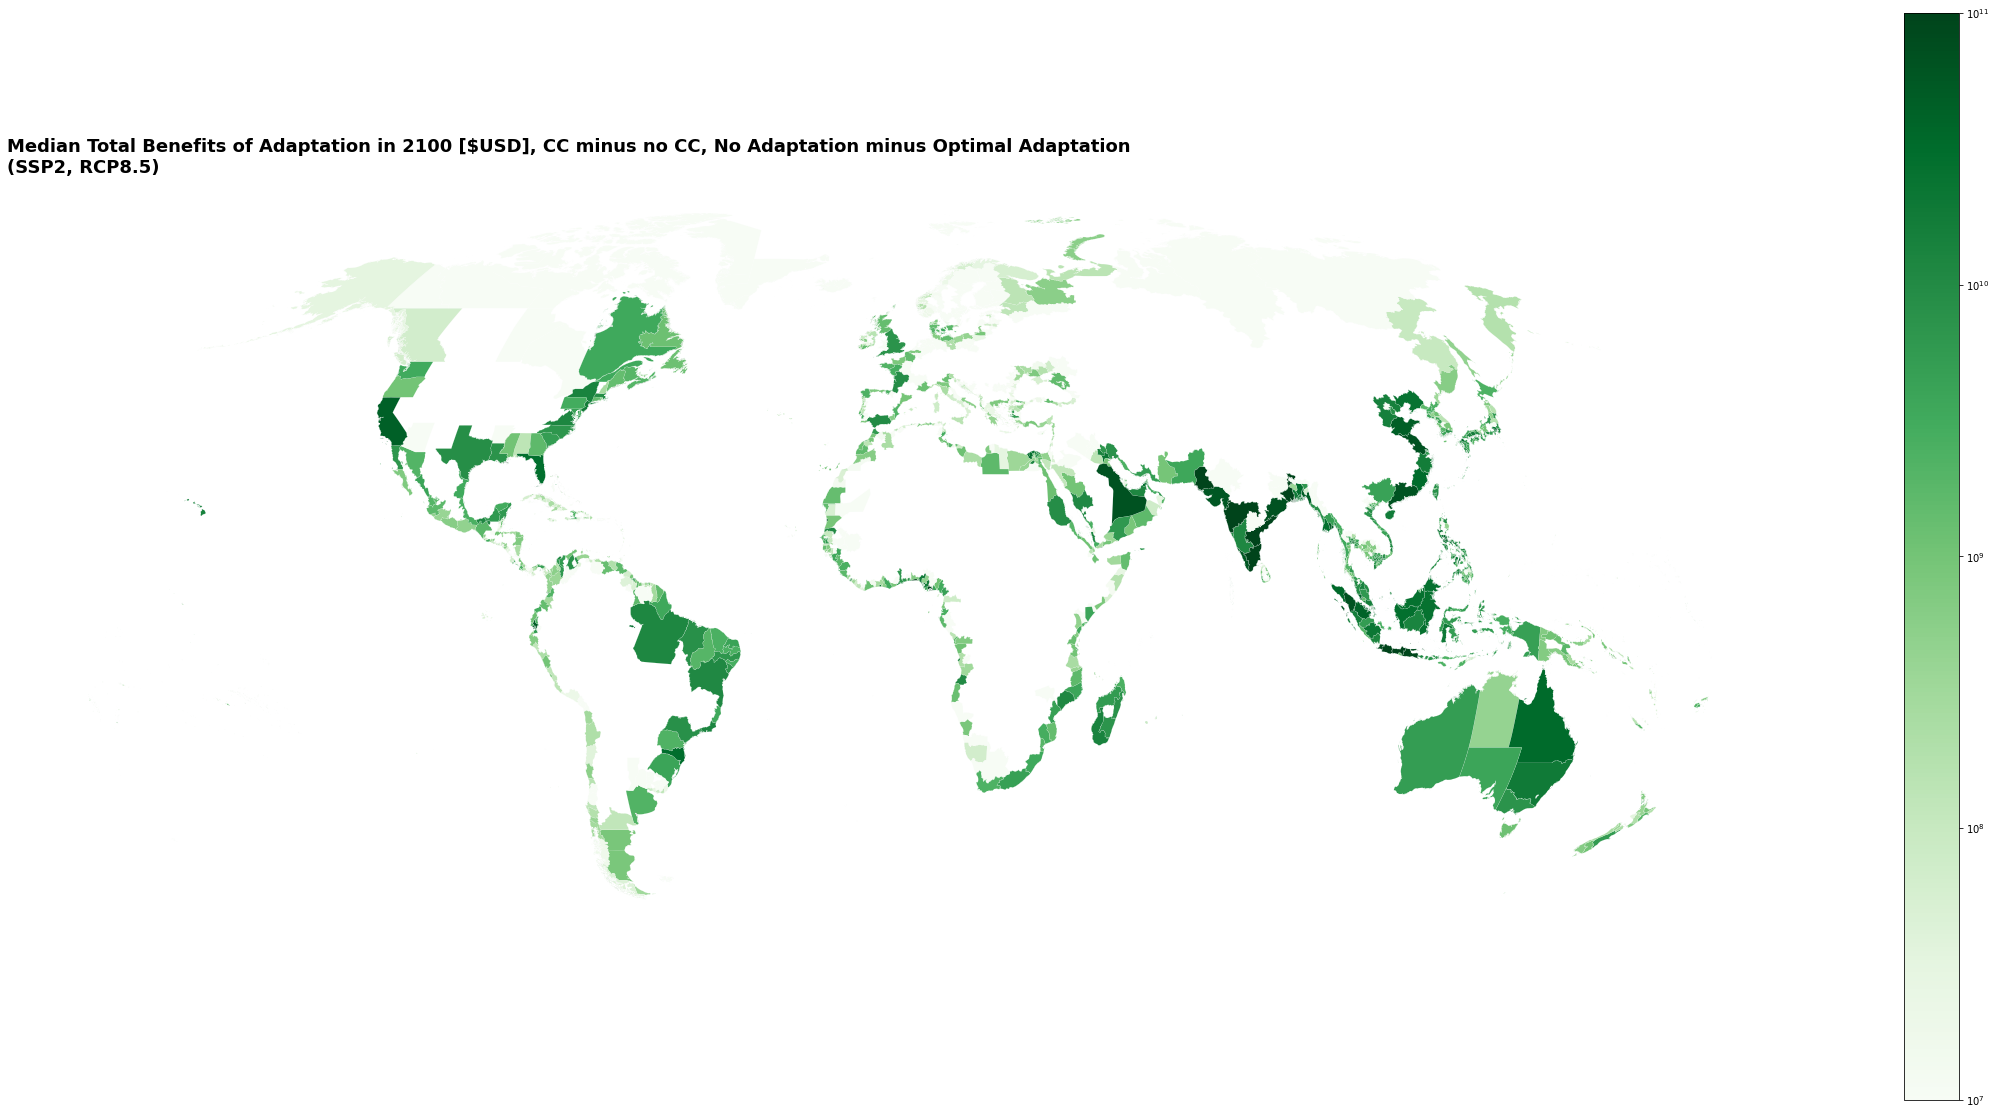

In [206]:
# Benefits of Adaptation in 2100 [USD]
costs_poly_plot(
    adm1,
    bb,
    "benAdapt",
    filename="map_adm1_global_benAdapt_CC_opt",
    title_main="Median Total Benefits of Adaptation in 2100 [$USD], CC minus no CC, No Adaptation minus Optimal Adaptation",
    vmin=1e7,
    vmax=1e11,
    cm="Greens",
)

### Optimal Adaptation Strategy

In [207]:
res.optimal_case

<xarray.DataArray 'optimal_case' (seg_adm: 11709, scenario: 2)>
array([[0, 0],
       [6, 6],
       [0, 0],
       ...,
       [6, 6],
       [6, 6],
       [6, 6]], dtype=uint8)
Coordinates:
  * scenario  (scenario) <U45 'ncc' 'SLRProjections210628GRIDDEDcore_SROCC_rc...
  * seg_adm   (seg_adm) <U23 'seg_00001_adm1_GRC.4_1' ... 'seg_99015_adm1_SXM'
Attributes:
    data_dictionary:  {'noAdaptation': 0, 'protect10': 1, 'protect100': 2, 'p...
    description:      Adaptation approach chosen by each segment
    long_name:        Lowest Cost Adaptation Approach

optimal_case  \
scenario                                    seg_adm                                 
ncc                                         seg_00001_adm1_GRC.4_1              0   
                                            seg_00002_adm1_GRC.4_1              6   
                                            seg_00003_adm1_GRC.1_1              0   
                                            seg_00008_adm1_ITA.15_1             6   
                                            seg_00009_adm1_ITA.15_1             6   
...                                                                           ...   
SLRProjections210628GRIDDEDcore_SROCC_rcp85 seg_99010_adm1_NRU.8_1              6   
                                            seg_99010_adm1_NRU.9_1              6   
                                            seg_99013_adm1_TKL.2_1              6   
                                            seg_99013_adm1_TKL.3_1              6   
                                            seg_99015_adm1_SXM                  6   

                                                                           lat  \
scenario                                    seg_adm                              
ncc                                         seg_00001_adm1_GRC.4_1   34.826660   
                                            seg_00002_adm1_GRC.4_1   34.870609   
                                            seg_00003_adm1_GRC.1_1   35.368649   
                                            seg_00008_adm1_ITA.15_1  35.500488   
                                            seg_00009_adm1_ITA.15_1  35.500488   
...                                                                        ...   
SLRProjections210628GRIDDEDcore_SROCC_rcp85 seg_99010_adm1_NRU.8_1   -0.540737   
                                            seg_99010_adm1_NRU.9_1   -0.540737   
                                            seg_99013_adm1_TKL.2_1   -9.341524   
                                            seg_99013_adm1_TKL.3_1   -9.341524   
                                            seg_99015_adm1_SXM       18.038858   

                                                                            lon  \
scenario                                    seg_adm                               
ncc                                         seg_00001_adm1_GRC.4_1    24.089359   
                                            seg_00002_adm1_GRC.4_1    24.089359   
                                            seg_00003_adm1_GRC.1_1    26.901859   
                                            seg_00008_adm1_ITA.15_1   12.575680   
                                            seg_00009_adm1_ITA.15_1   12.619630   
...                                                                         ...   
SLRProjections210628GRIDDEDcore_SROCC_rcp85 seg_99010_adm1_NRU.8_1   166.914062   
                                            seg_99010_adm1_NRU.9_1   166.914062   
                                            seg_99013_adm1_TKL.2_1  -171.192642   
                                            seg_99013_adm1_TKL.3_1  -171.192642   
                                            seg_99015_adm1_SXM       -63.014824   

                                                                         adm1  \
scenario                                    seg_adm                             
ncc                                         seg_00001_adm1_GRC.4_1    GRC.4_1   
                                            seg_00002_adm1_GRC.4_1    GRC.4_1   
                                            seg_00003_adm1_GRC.1_1    GRC.1_1   
                                            seg_00008_adm1_ITA.15_1  ITA.15_1   
                                            seg_00009_adm1_ITA.15_1  ITA.15_1   
...                                                                       ...   
SLRProjections210628GRIDDEDcore_SROCC_rcp85 seg_99010_adm1_NRU.8_1    NRU.8_1   
                                            seg_99010_adm1_NRU.9_1    NRU.9_1   
      

In [217]:
adapt

scenario                  seg_adm  \
0      SLRProjections210628GRIDDEDcore_SROCC_rcp85   seg_00001_adm1_GRC.4_1   
1      SLRProjections210628GRIDDEDcore_SROCC_rcp85   seg_00002_adm1_GRC.4_1   
2      SLRProjections210628GRIDDEDcore_SROCC_rcp85   seg_00003_adm1_GRC.1_1   
3      SLRProjections210628GRIDDEDcore_SROCC_rcp85  seg_00008_adm1_ITA.15_1   
4      SLRProjections210628GRIDDEDcore_SROCC_rcp85  seg_00009_adm1_ITA.15_1   
...                                            ...                      ...   
11704  SLRProjections210628GRIDDEDcore_SROCC_rcp85   seg_99010_adm1_NRU.8_1   
11705  SLRProjections210628GRIDDEDcore_SROCC_rcp85   seg_99010_adm1_NRU.9_1   
11706  SLRProjections210628GRIDDEDcore_SROCC_rcp85   seg_99013_adm1_TKL.2_1   
11707  SLRProjections210628GRIDDEDcore_SROCC_rcp85   seg_99013_adm1_TKL.3_1   
11708  SLRProjections210628GRIDDEDcore_SROCC_rcp85       seg_99015_adm1_SXM   

       optimal_case        lat         lon      adm1        seg seg_country  
0                 0  34.826660   24.089359   GRC.4_1  seg_00001         GRC  
1                 6  34.870609   24.089359   GRC.4_1  seg_00002         GRC  
2                 0  35.368649   26.901859   GRC.1_1  seg_00003         GRC  
3                 6  35.500488   12.575680  ITA.15_1  seg_00008         ITA  
4                 6  35.500488   12.619630  ITA.15_1  seg_00009         ITA  
...             ...        ...         ...       ...        ...         ...  
11704             6  -0.540737  166.914062   NRU.8_1  seg_99010         NRU  
11705             6  -0.540737  166.914062   NRU.9_1  seg_99010         NRU  
11706             6  -9.341524 -171.192642   TKL.2_1  seg_99013         TKL  
11707             6  -9.341524 -171.192642   TKL.3_1  seg_99013         TKL  
11708             6  18.038858  -63.014824       SXM  seg_99015         SXM  

[11709 rows x 8 columns]

In [218]:
cost_df

costs_2100_med_optimalfixed  \
seg_adm                                                
seg_00001_adm1_GRC.4_1                  2.453462e+04   
seg_00002_adm1_GRC.4_1                  1.201649e+05   
seg_00003_adm1_GRC.1_1                  6.786340e+05   
seg_00008_adm1_ITA.15_1                 2.318388e+05   
seg_00009_adm1_ITA.15_1                 2.426262e+06   
...                                              ...   
seg_99010_adm1_NRU.8_1                  7.547415e+05   
seg_99010_adm1_NRU.9_1                  7.353936e+04   
seg_99013_adm1_TKL.2_1                  5.154291e+05   
seg_99013_adm1_TKL.3_1                  4.385057e+05   
seg_99015_adm1_SXM                      7.745016e+06   

                         wetland_costs_2100_med_optimalfixed  \
seg_adm                                                        
seg_00001_adm1_GRC.4_1                               0.00000   
seg_00002_adm1_GRC.4_1                               0.00000   
seg_00003_adm1_GRC.1_1                               0.00000   
seg_00008_adm1_ITA.15_1                              0.00000   
seg_00009_adm1_ITA.15_1                              0.00000   
...                                                      ...   
seg_99010_adm1_NRU.8_1                               0.00000   
seg_99010_adm1_NRU.9_1                               0.00000   
seg_99013_adm1_TKL.2_1                               0.00000   
seg_99013_adm1_TKL.3_1                               0.00000   
seg_99015_adm1_SXM                              466119.28125   

                         inundation_costs_2100_med_optimalfixed  \
seg_adm                                                           
seg_00001_adm1_GRC.4_1                             1.886067e+04   
seg_00002_adm1_GRC.4_1                             9.383828e+04   
seg_00003_adm1_GRC.1_1                             2.695444e+05   
seg_00008_adm1_ITA.15_1                            8.617492e+04   
seg_00009_adm1_ITA.15_1                            5.726749e+05   
...                                                         ...   
seg_99010_adm1_NRU.8_1                             1.715457e+05   
seg_99010_adm1_NRU.9_1                             2.777887e+04   
seg_99013_adm1_TKL.2_1                             3.689013e+05   
seg_99013_adm1_TKL.3_1                             3.049597e+05   
seg_99015_adm1_SXM                                 1.651567e+06   

                         relocation_costs_2100_med_optimalfixed  \
seg_adm                                                           
seg_00001_adm1_GRC.4_1                             3.369407e+03   
seg_00002_adm1_GRC.4_1                             2.568648e+04   
seg_00003_adm1_GRC.1_1                             1.280286e+05   
seg_00008_adm1_ITA.15_1                            1.432263e+05   
seg_00009_adm1_ITA.15_1                            1.814115e+06   
...                                                         ...   
seg_99010_adm1_NRU.8_1                             5.617570e+05   
seg_99010_adm1_NRU.9_1                             4.329665e+04   
seg_99013_adm1_TKL.2_1                             1.429290e+05   
seg_99013_adm1_TKL.3_1                             1.283863e+05   
seg_99015_adm1_SXM                                 5.171711e+06   

                         protection_costs_2100_med_optimalfixed  \
seg_adm                                                           
seg_00001_adm1_GRC.4_1                                      0.0   
seg_00002_adm1_GRC.4_1                                      0.0   
seg_00003_adm1_GRC.1_1                                      0.0   
seg_00008_adm1_ITA.15_1                                     0.0   
seg_00009_adm1_ITA.15_1                                     0.0   
...                                                         ...   
seg_99010_adm1_NRU.8_1                                      0.0   
seg_99010_adm1_NRU.9_1                                      0.0   
seg_99013_adm1_TKL.2_1                           

In [222]:
# create dataframe of optimal case code results for mapping (for SLR scenario only)
adapt = (
    xr.merge(
        (
            res.optimal_case,
            inputs[["seg_lat", "seg_lon"]].rename(seg_lat="lat", seg_lon="lon").load(),
        )
    )
    .to_dataframe()
    .drop("ncc", level="scenario")
    .join(cost_df["pop"])
    .reset_index(drop=False)
)

# Simplify from seg_adm to seg
adapt = adapt.groupby("seg").agg(
    optimal_case=("optimal_case", "mean"),
    lon=("lon", "mean"),
    lat=("lat", "mean"),
    pop=("pop", "sum"),
)

gdf = gpd.GeoDataFrame(
    adapt[["optimal_case", "pop"]],
    geometry=gpd.points_from_xy(adapt["lon"], adapt["lat"]),
)

gdf.crs = "epsg:4326"

gdf["adapt_type"] = gdf["optimal_case"].apply(
    lambda c: {
        0: "NOADAPT",
        1: "PROTECT",
        2: "PROTECT",
        3: "PROTECT",
        4: "PROTECT",
        5: "RETREAT",
        6: "RETREAT",
        7: "RETREAT",
        8: "RETREAT",
        9: "RETREAT",
    }[c]
)

# Create separate retreat, protect, noAdapt gdfs for plotting
gdf["log10pop"] = np.log10(gdf["pop"])
gdf.loc[gdf["pop"] < 1, "log10pop"] = 0  # set zero or fractional (<1) pops to 0
r_gdf = gdf[gdf.adapt_type == "RETREAT"].sort_values("optimal_case")
p_gdf = gdf[gdf.adapt_type == "PROTECT"].sort_values("optimal_case")
n_gdf = gdf[gdf.adapt_type == "NOADAPT"].sort_values("optimal_case")

/srv/conda/envs/notebook/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Plotting Function

In [232]:
# Coastal IRs colored
def adapt_plot(
    gdf,
    val_col="optimal_case",
    adapt_type="RETREAT",
    title_main="my plot",
    title_sub="\n(=SSP2, IIASA, RCP8.5)",
    filename="myplot.png",
    vmin=0,
    vmax=300,
    alpha=0.8,
    msize=120,
    cm="YlGnBu",
):
    """creates map of results values for given scenario for geographic boundaries (e.g. national, ADM1)

    ----------
    gdf : gdp.GeoDataFrame
        gdf with optimal adaptation results joined with segment centroid SHP
    val_col : str
        name of variable to plot
    adapt_type : str
        which type of adaptation strategies to plot (PROTECT, RETREAT, NOADAPT)
    title_main : str
        map title to display
    title_sub : str
        map subtitle to display
    filename : str
        name of saved map file .png
    vmin, vmax : int or float
        range of color scale variable (z values) on map
    alpha : float
        opacity of plotted points
    msize : int
        point marker size
    cm : int
        color map for plot
    """
    fig, ax = plt.subplots(1, 1, frameon=False)
    fig.set_figheight(20)
    fig.set_figwidth(40)
    title_name = title_main
    title_name += title_sub
    ax.set_title(
        title_name,
        fontsize=18,
        loc="left",
        fontweight="bold",
    )
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")

    # International Borders
    borders.to_crs("ESRI:54030").plot(
        ax=ax, facecolor="none", edgecolor="#808080", linewidth=1, alpha=0.5, zorder=5
    )

    # Coastlines
    clines.to_crs("ESRI:54030").plot(
        ax=ax, edgecolor="#808080", linewidth=1, alpha=0.5, zorder=0
    )

    gdf.sort_values(val_col).to_crs("ESRI:54030").plot(
        column=val_col,
        ax=ax,
        legend=True,
        cmap=cm,
        vmin=vmin,
        vmax=vmax,
        markersize=msize,
        edgecolor="#808080",
        linewidth=0,
        alpha=alpha,
        zorder=10,
    )

    plt.savefig(DIR_FIGS / str(filename + ".png"))

#### Retreat Plot

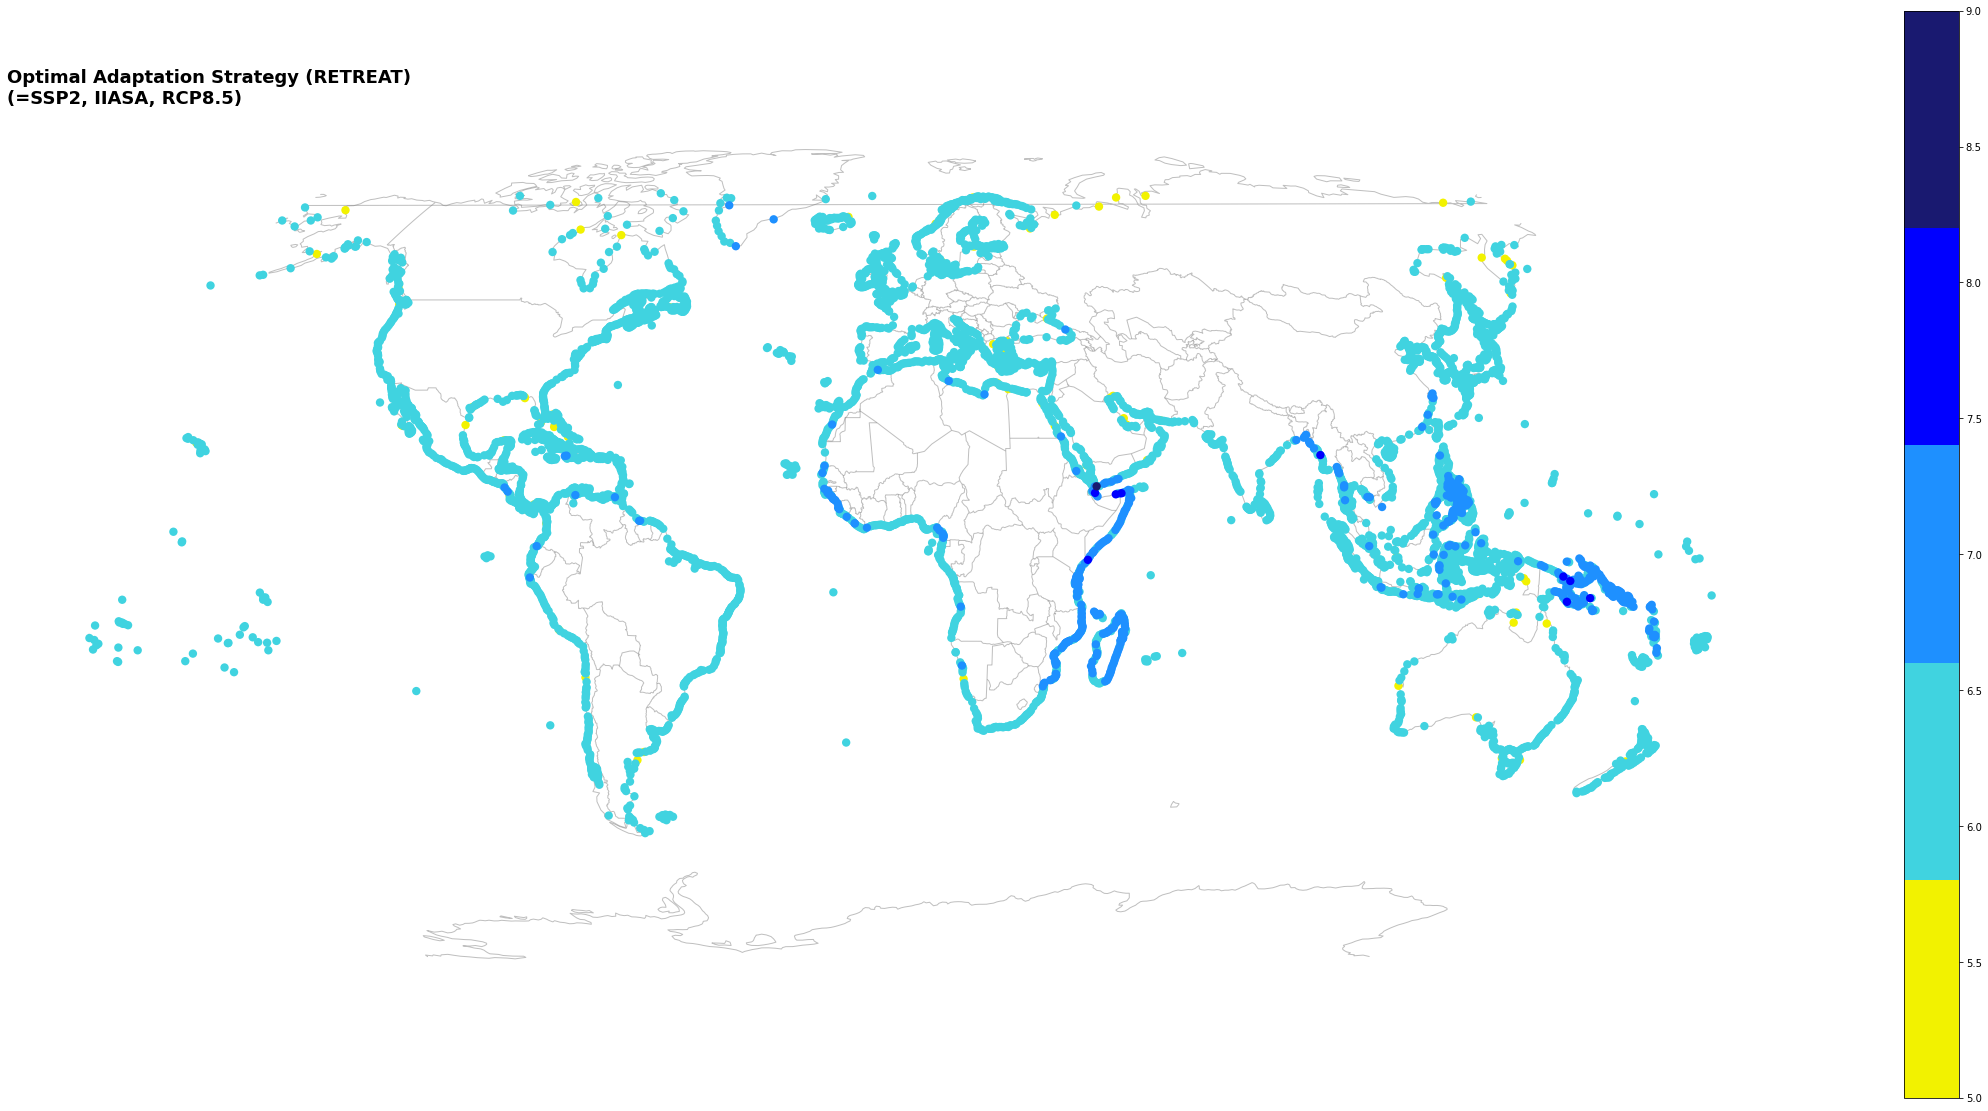

In [233]:
# r_colors = ["yellow", "skyblue", "royalblue", "darkblue", "black"]
r_colors = ["#f2f200", "#40d3e0", "dodgerblue", "blue", "midnightblue"]

r_cmap = LinearSegmentedColormap.from_list("cm", r_colors, N=5)

adapt_plot(
    r_gdf,
    title_main="Optimal Adaptation Strategy (RETREAT)",
    filename="optAdapt_map_retreat",
    vmin=5,
    vmax=9,
    alpha=1,
    msize=70,
    cm=r_cmap,
)

#### Protect Plot

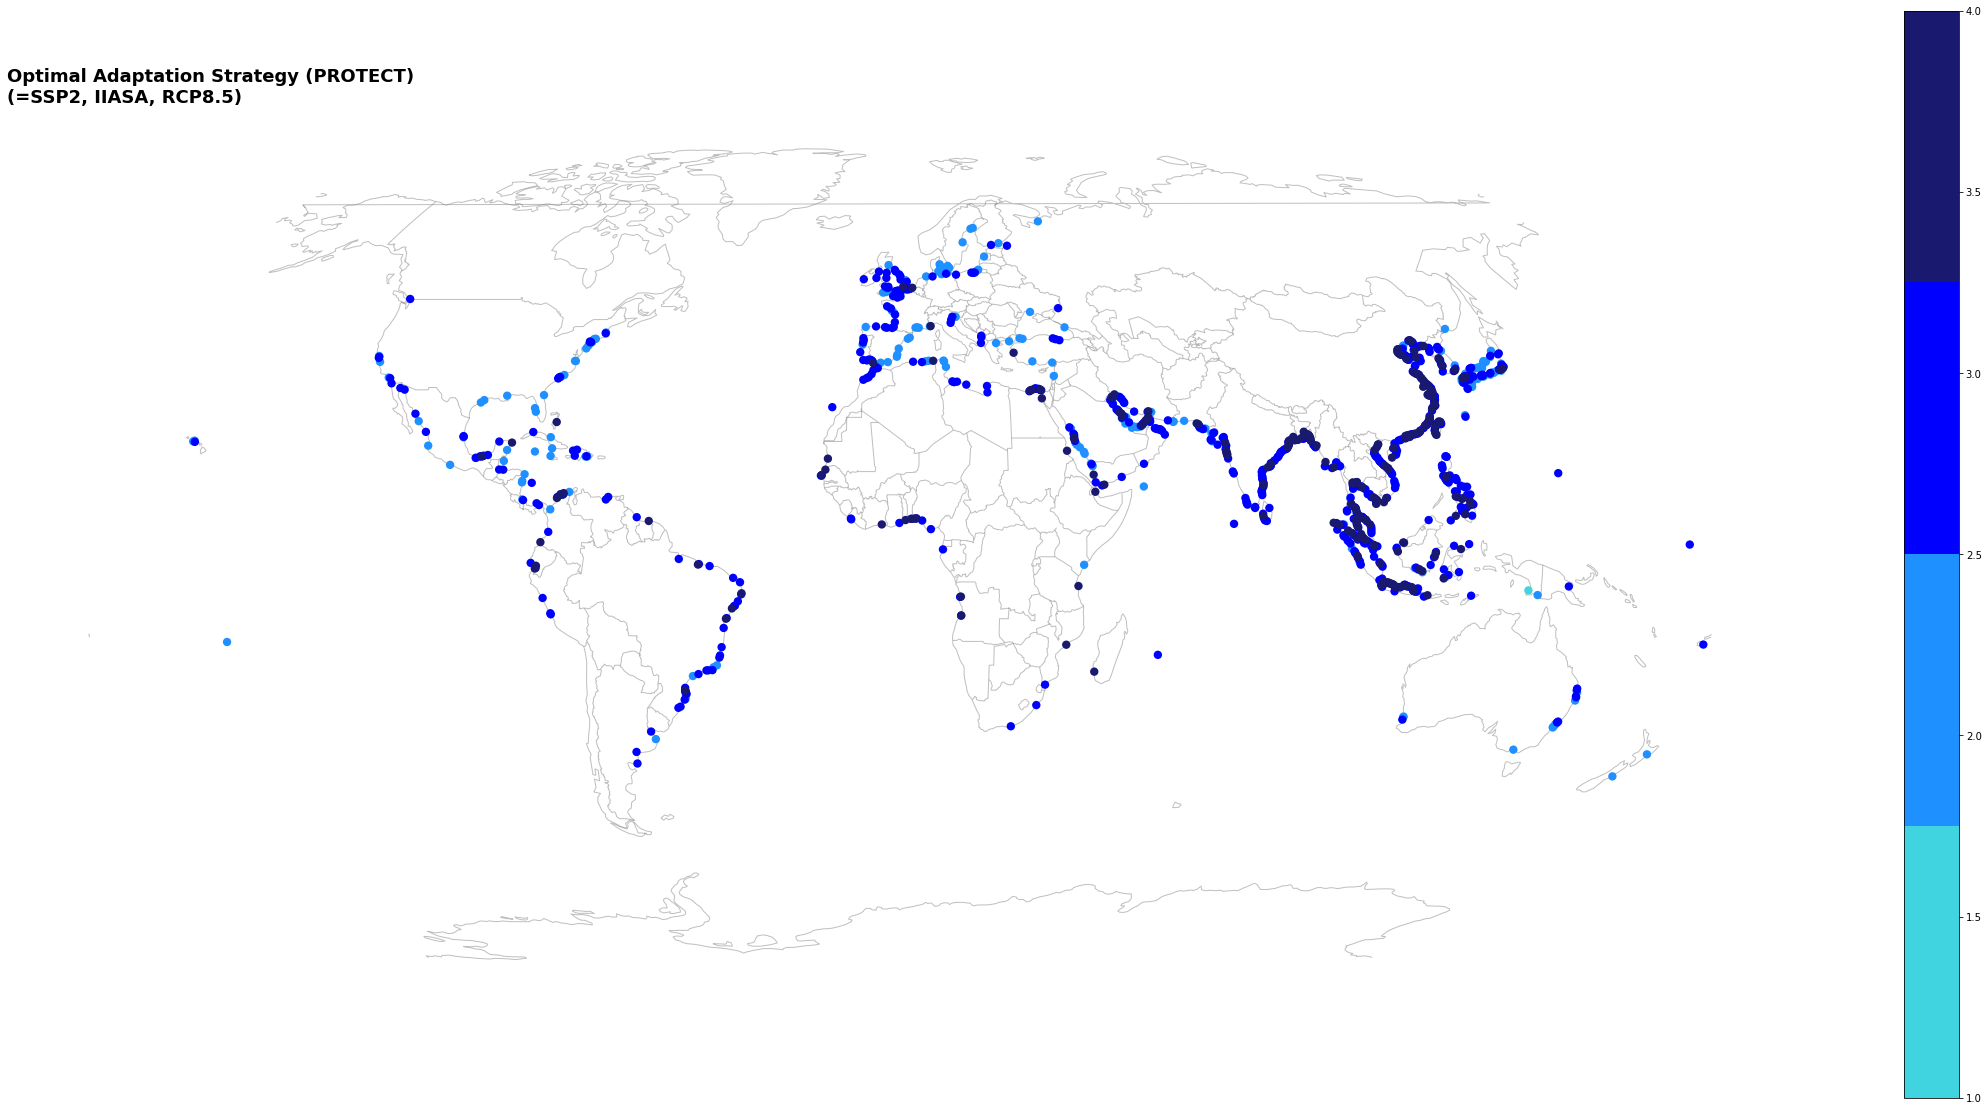

In [234]:
p_colors = ["#40d3e0", "dodgerblue", "blue", "midnightblue"]
p_cmap = LinearSegmentedColormap.from_list("cm", p_colors, N=4)

adapt_plot(
    p_gdf,
    title_main="Optimal Adaptation Strategy (PROTECT)",
    filename="optAdapt_map_protect",
    vmin=1,
    vmax=4,
    alpha=1,
    msize=70,
    cm=p_cmap,
)

#### No Adapt Plot

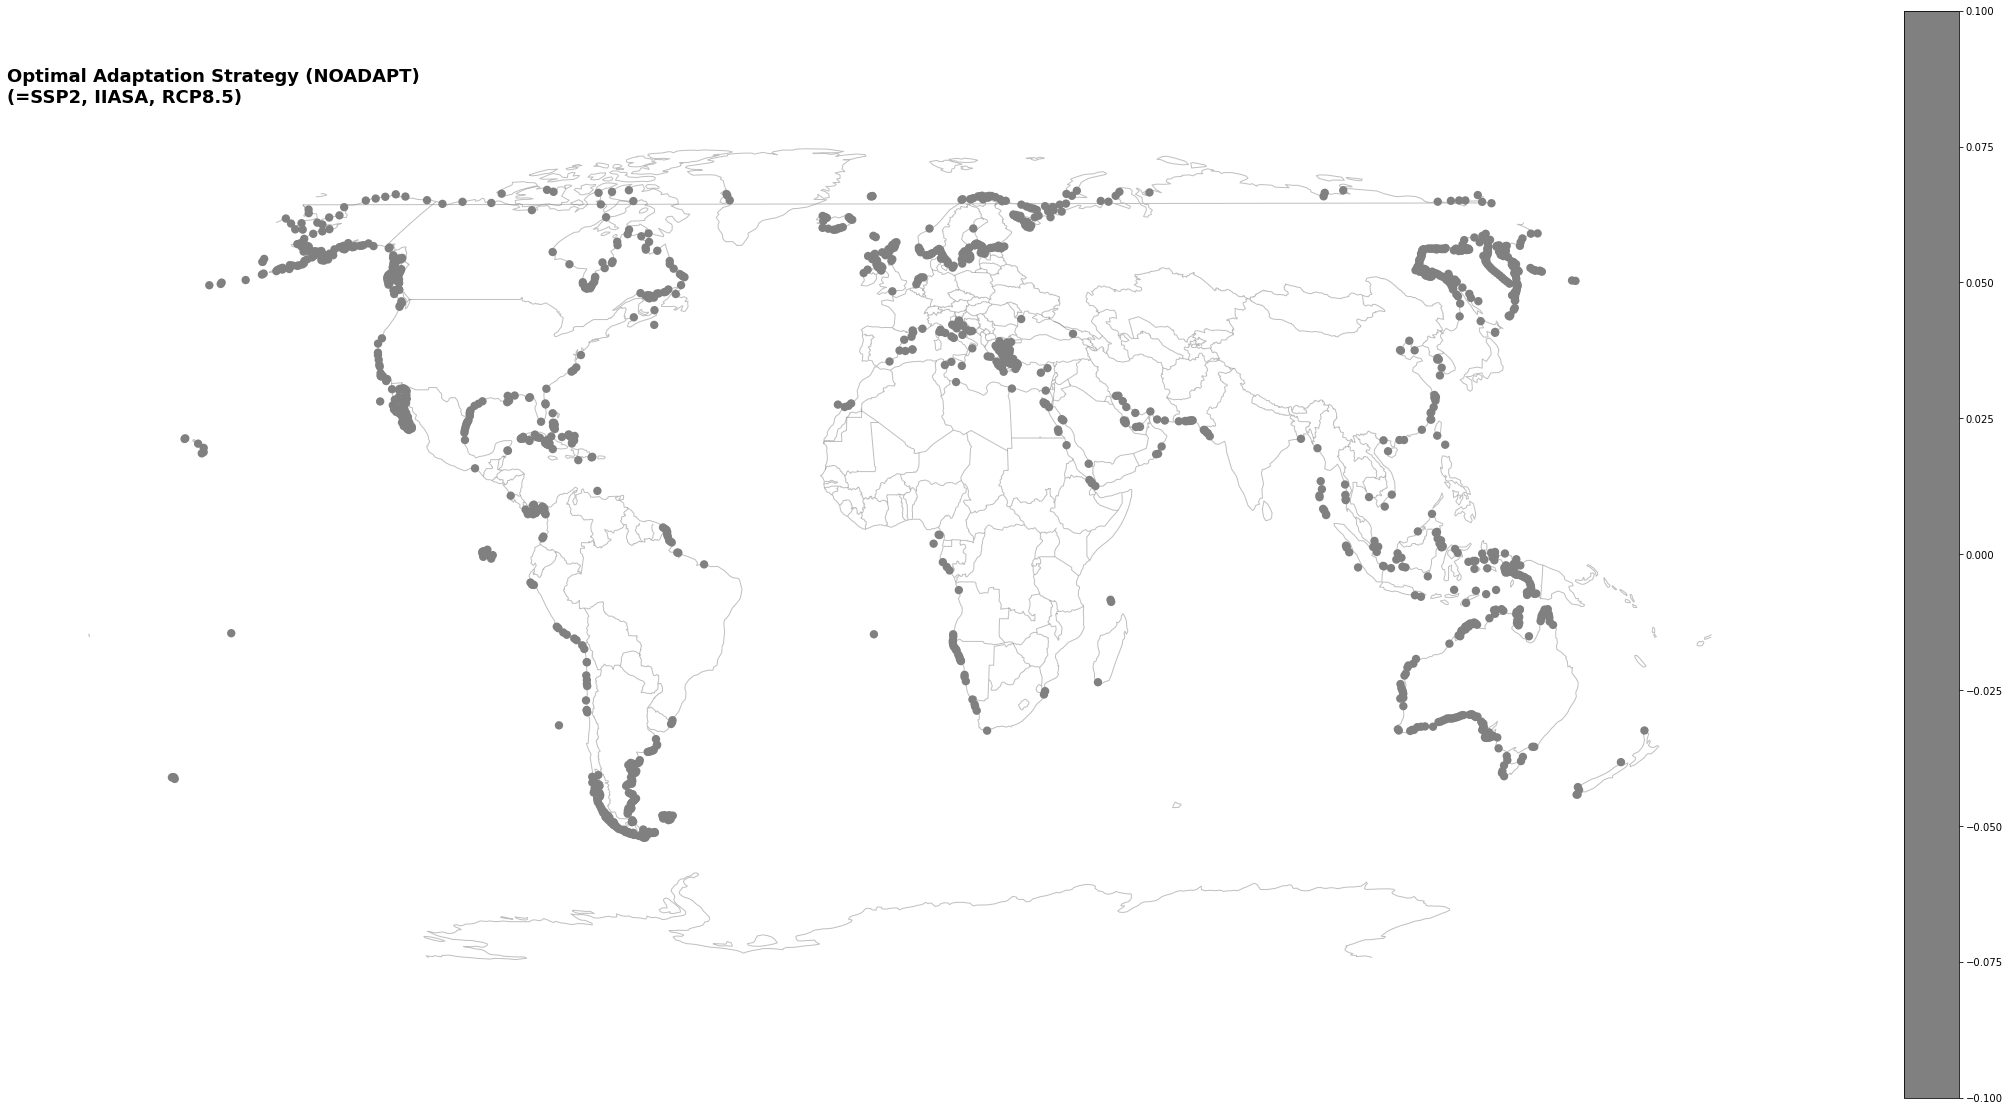

In [235]:
na_colors = ["grey", "grey"]
na_cmap = LinearSegmentedColormap.from_list("cm", na_colors, N=2)

adapt_plot(
    n_gdf,
    title_main="Optimal Adaptation Strategy (NOADAPT)",
    filename="optAdapt_map_noAdapt",
    vmin=0,
    vmax=0,
    alpha=1,
    msize=70,
    cm=na_cmap,
)

### Population Adaptation Plots

(array([426.,  60.,  91., 105., 148., 132., 177., 210., 290., 392., 445.,
        563., 664., 675., 777., 762., 704., 683., 564., 412., 315., 213.,
        124.,  70.,  44.,  21.,  14.,   3.,   2.,   1.]),
 array([0.        , 0.26225632, 0.52451265, 0.786769  , 1.0490253 ,
        1.3112816 , 1.573538  , 1.8357942 , 2.0980506 , 2.360307  ,
        2.6225631 , 2.8848195 , 3.147076  , 3.4093323 , 3.6715884 ,
        3.9338448 , 4.196101  , 4.4583573 , 4.720614  , 4.98287   ,
        5.2451262 , 5.507383  , 5.769639  , 6.031895  , 6.294152  ,
        6.556408  , 6.8186646 , 7.0809207 , 7.343177  , 7.6054335 ,
        7.8676896 ], dtype=float32),
 <BarContainer object of 30 artists>)

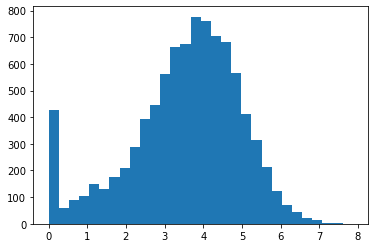

In [236]:
plt.hist(gdf["log10pop"], bins=30)

#### Retreat

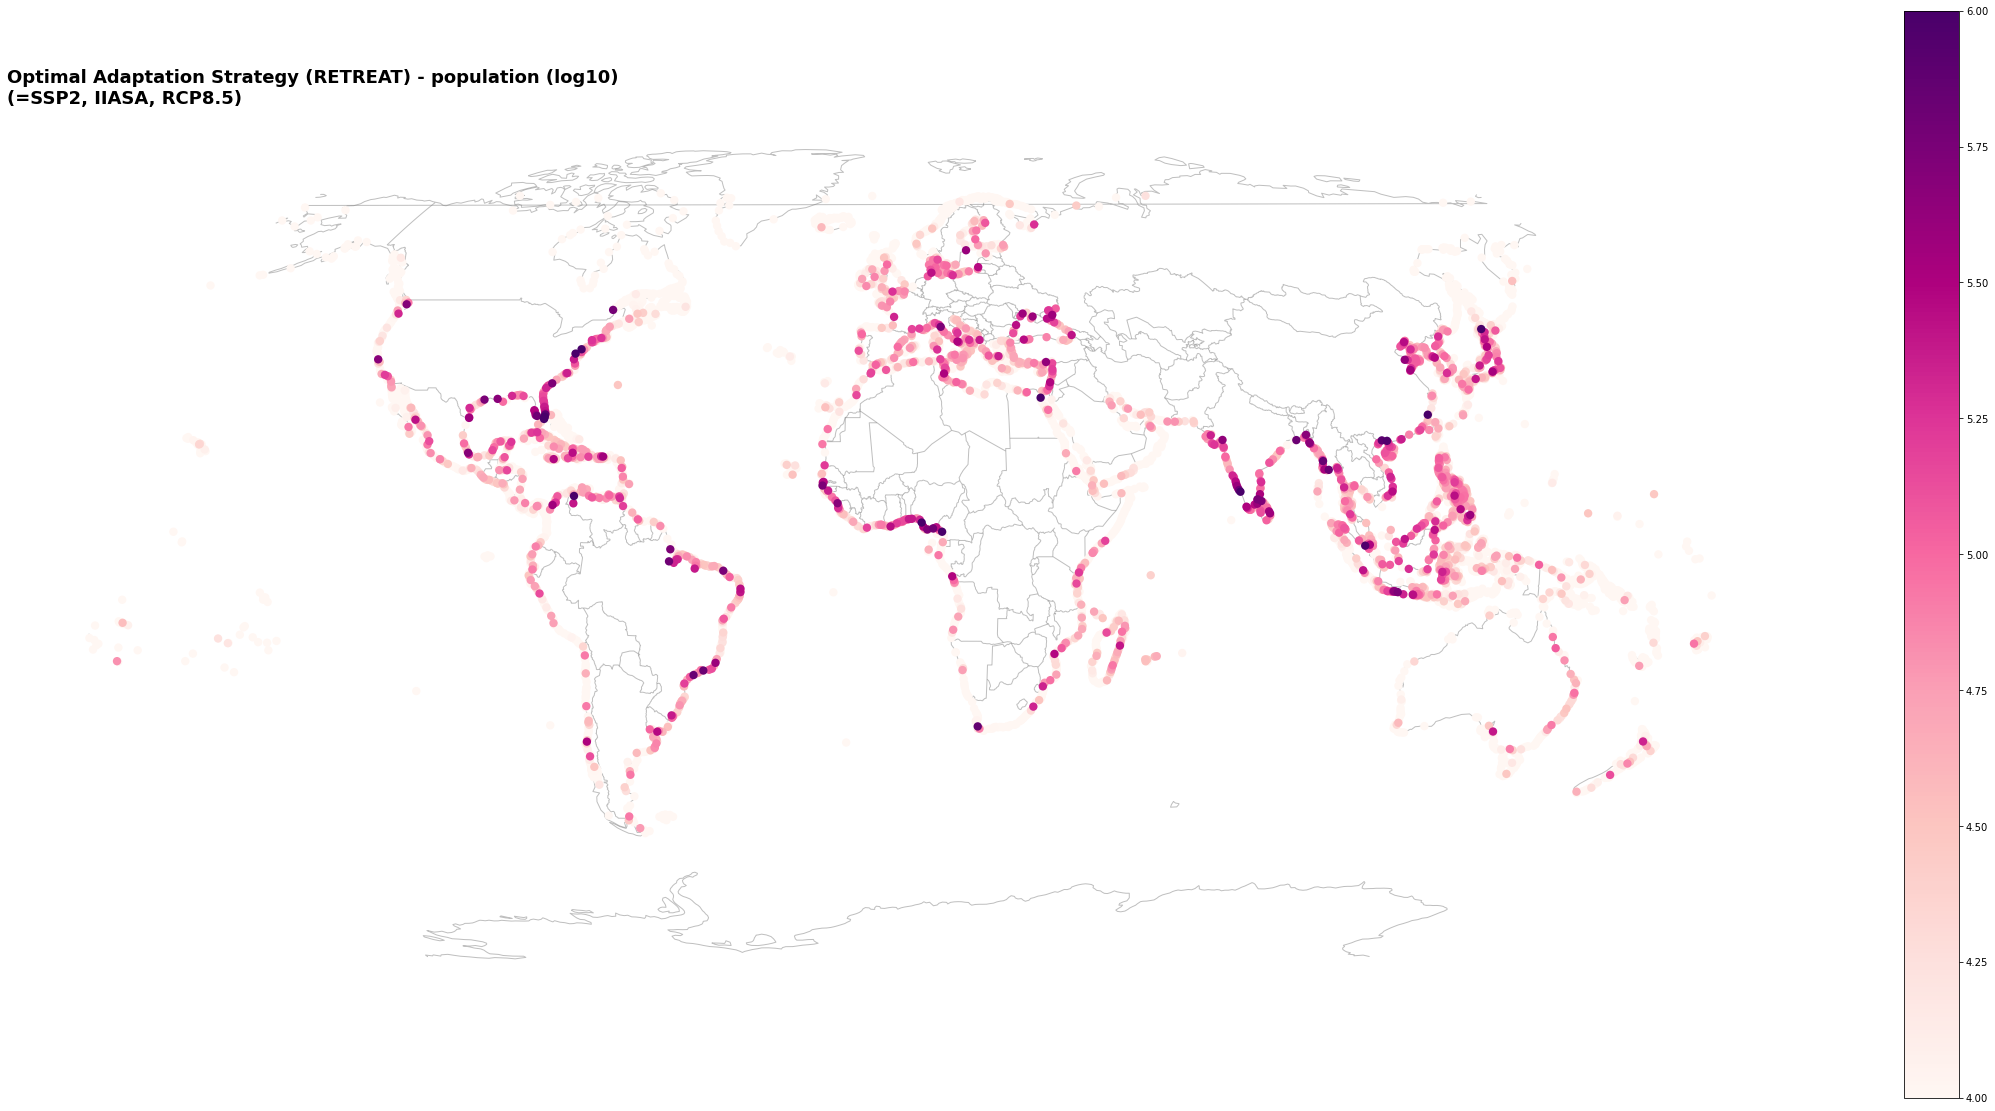

In [237]:
adapt_plot(
    r_gdf,
    val_col="log10pop",
    title_main="Optimal Adaptation Strategy (RETREAT) - population (log10)",
    filename="optAdapt_map_retreat_pop",
    vmin=4,
    vmax=6,
    alpha=1,
    msize=70,
    cm="RdPu",
)

#### Protect

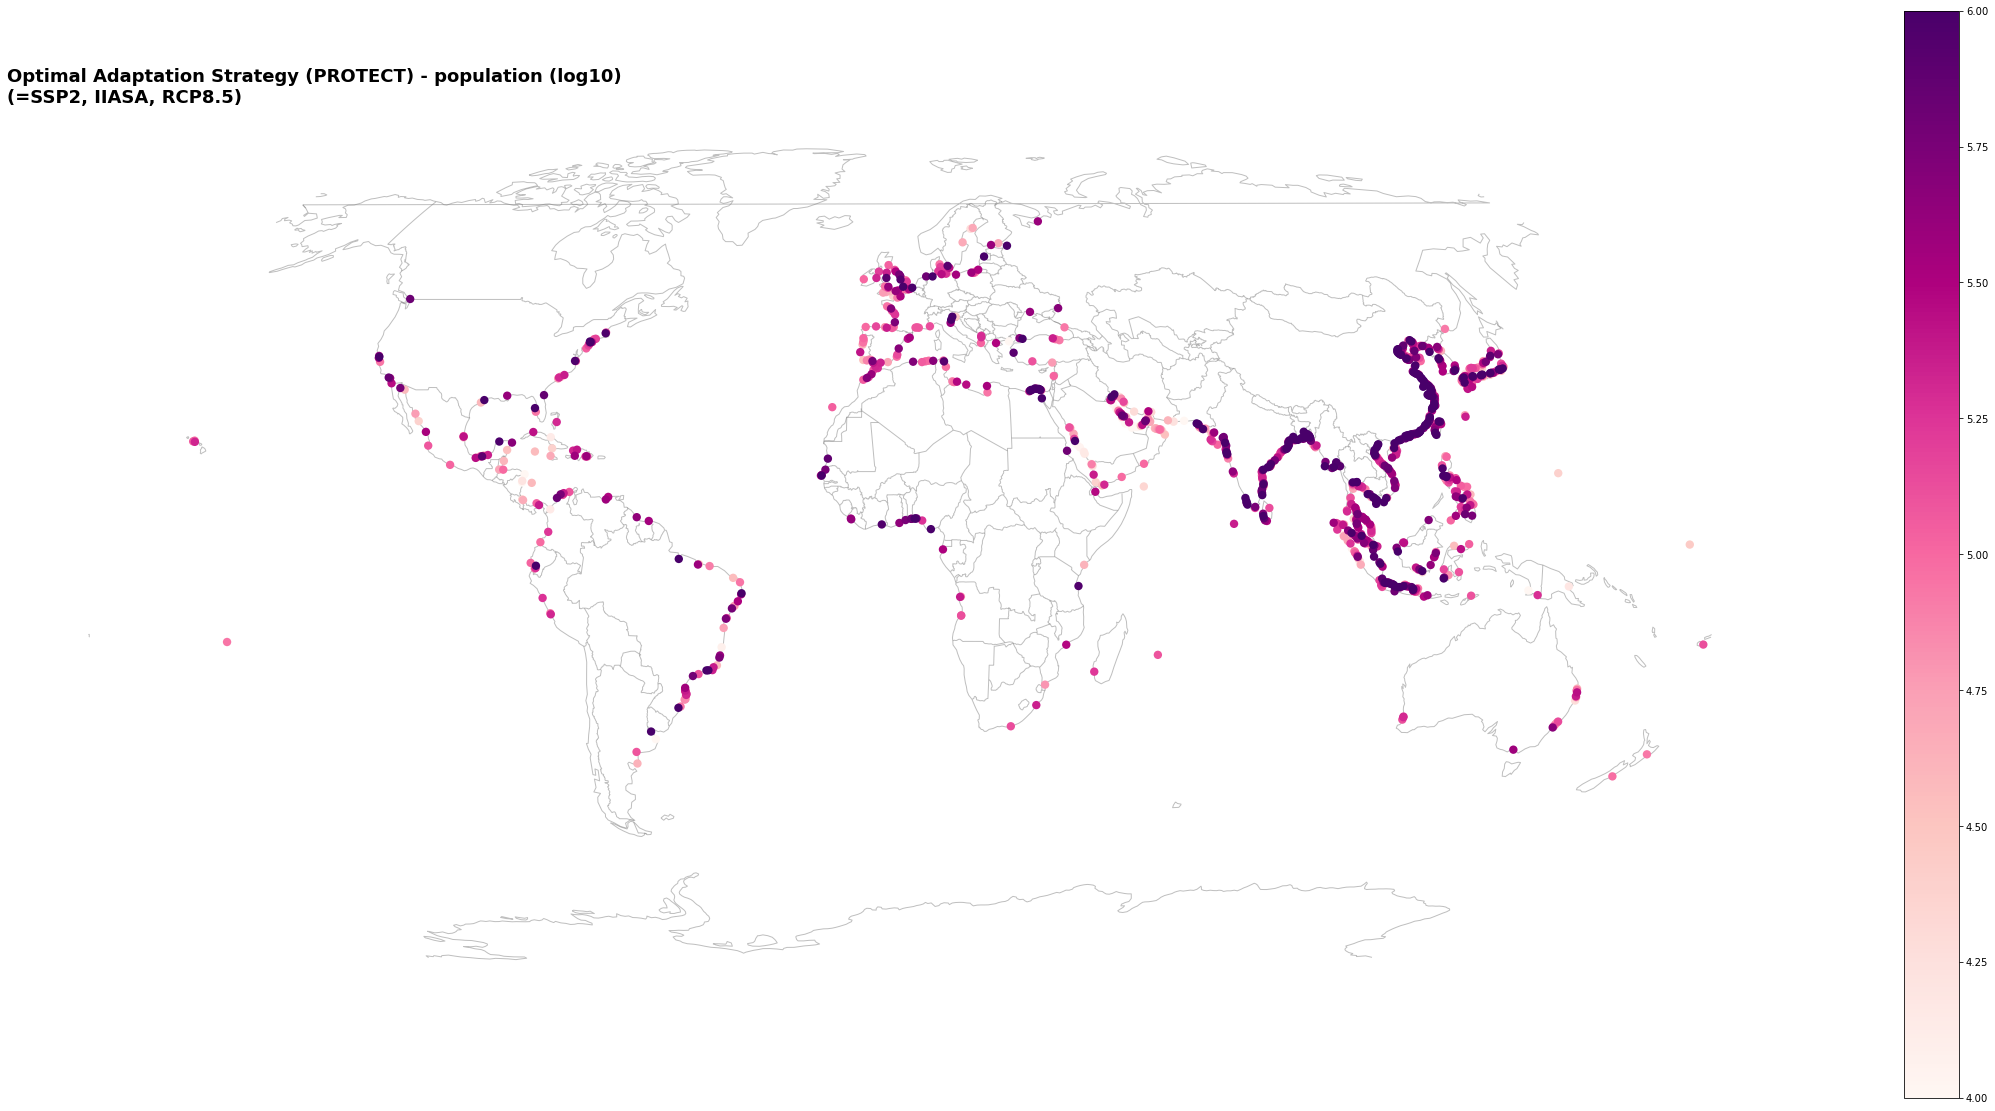

In [238]:
adapt_plot(
    p_gdf,
    val_col="log10pop",
    title_main="Optimal Adaptation Strategy (PROTECT) - population (log10)",
    filename="optAdapt_map_protect_pop",
    vmin=4,
    vmax=6,
    alpha=1,
    msize=70,
    cm="RdPu",
)

#### No Adapt

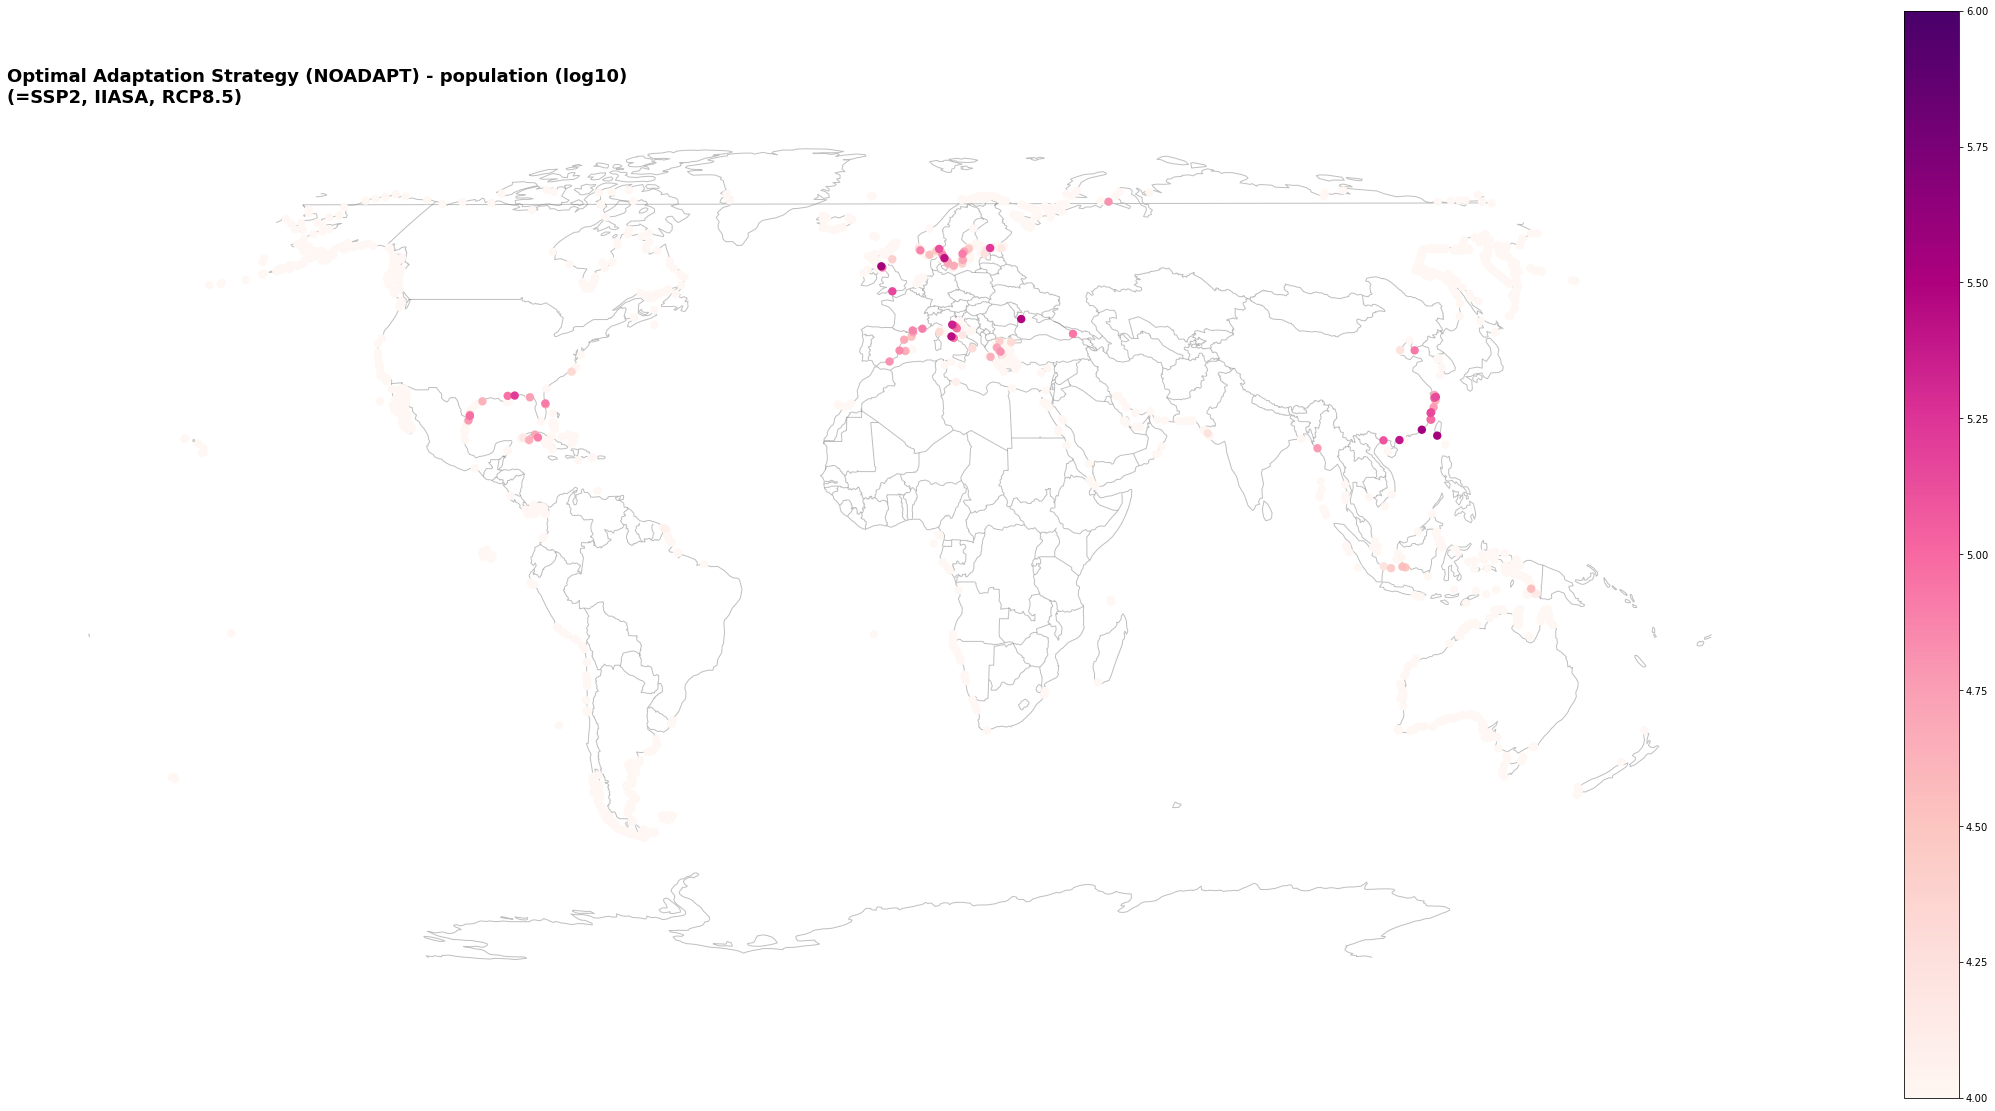

In [240]:
adapt_plot(
    n_gdf,
    val_col="log10pop",
    title_main="Optimal Adaptation Strategy (NOADAPT) - population (log10)",
    filename="optAdapt_map_noadapt_pop",
    vmin=4,
    vmax=6,
    alpha=1,
    msize=70,
    cm="RdPu",
)

#### Proactive or Reactive Retreat

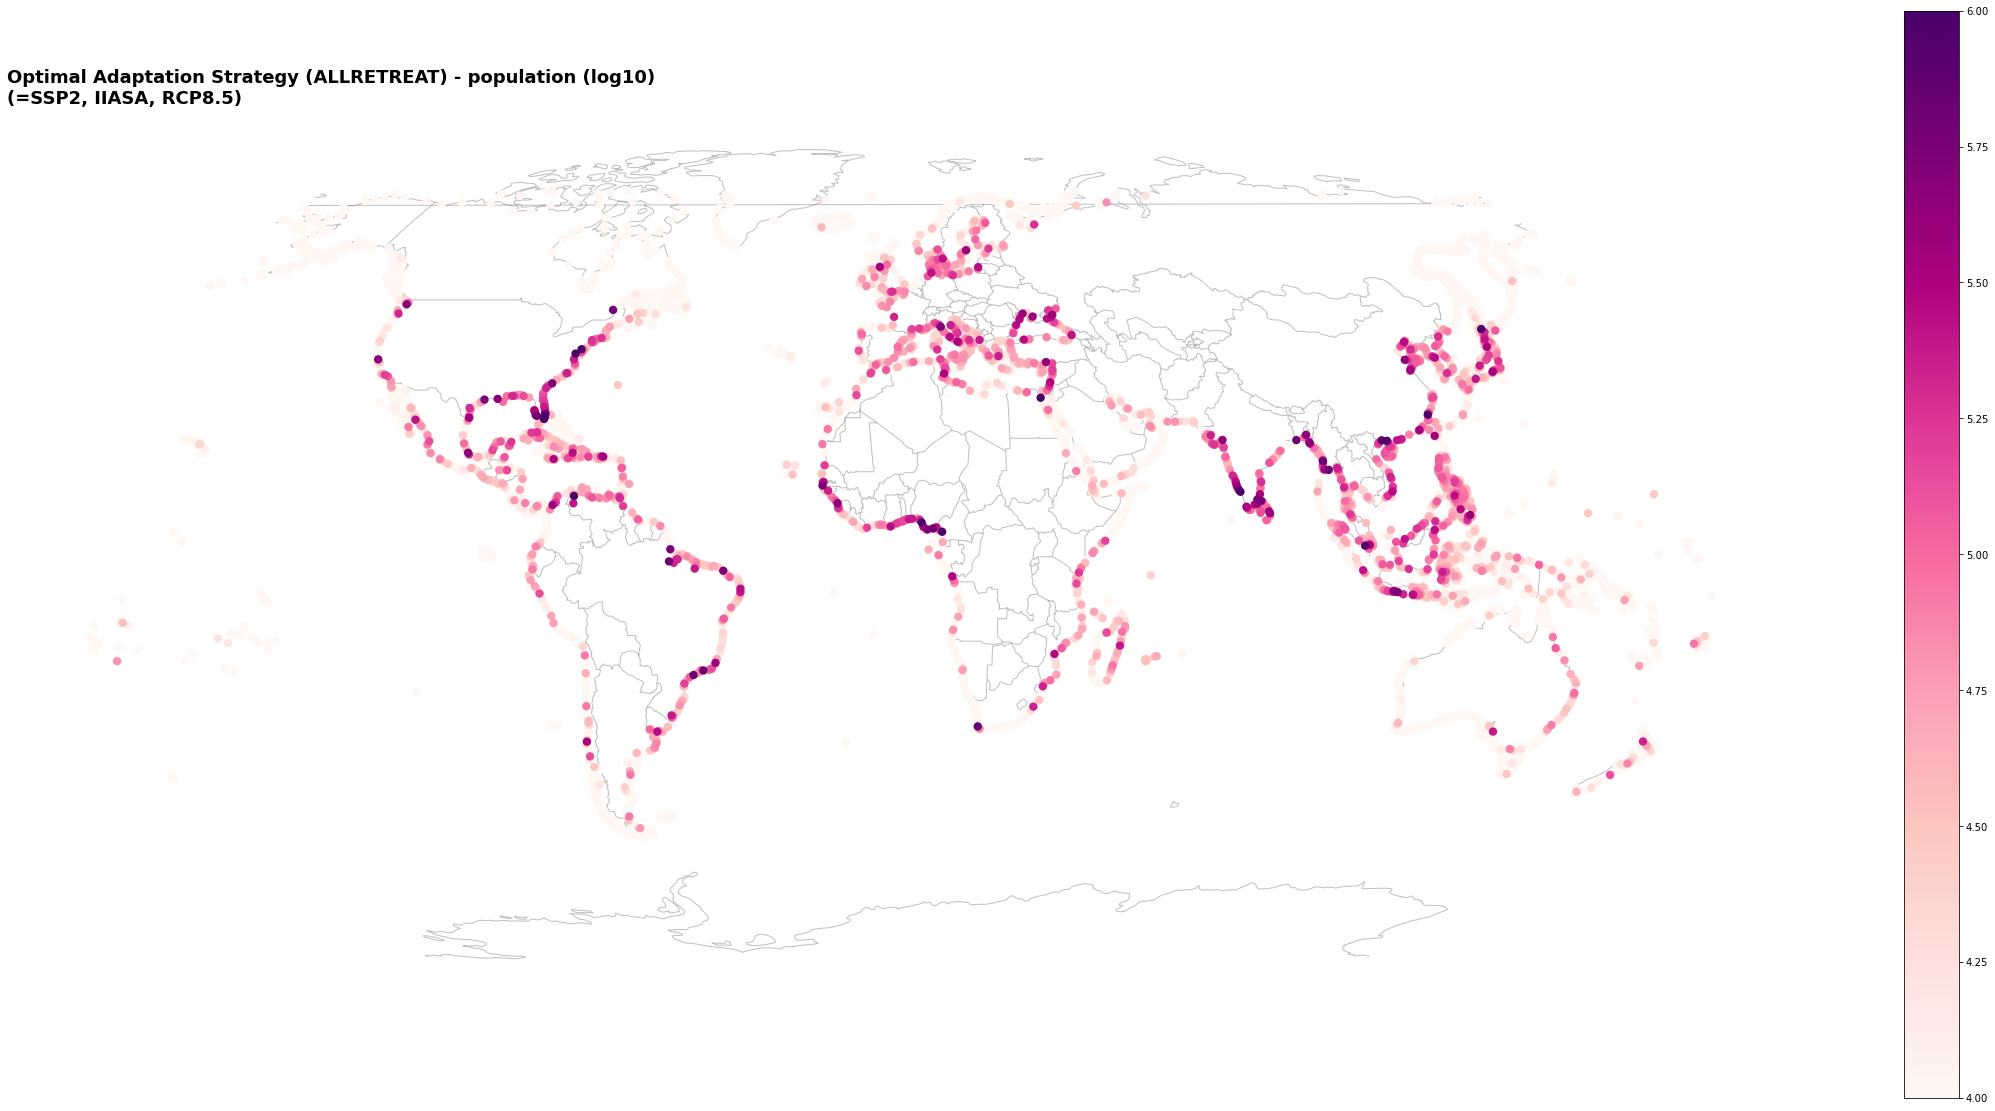

In [239]:
adapt_plot(
    pd.concat([r_gdf, n_gdf]),
    val_col="log10pop",
    title_main="Optimal Adaptation Strategy (ALLRETREAT) - population (log10)",
    filename="optAdapt_map_retreat_and_noadapt_pop",
    vmin=4,
    vmax=6,
    alpha=1,
    msize=70,
    cm="RdPu",
)